In [ ]:
#Clark Benham 
import numpy as np
import pandas as pd
import math
from scipy.stats import norm, lognorm
import matplotlib.pyplot as plt
from matplotlib import animation
import random 
from pprint import pprint      
import itertools


def brownian(x0, n, sd = None, loc = None, dt = 1, out = None):
    "Computes the brownian motion with an average increase of loc and DAILY SD of sd. \
    dt is how many prices per day"
    if not out:
        out = np.ones(n)
    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    sd = sd or 0.16/(256**0.5)#average actualy market vol
    loc = loc or (1.08)**(1/256)
    r = norm.rvs(loc = loc, size=n, scale=sd*math.sqrt(dt))
    # This computes geometrix Brownian motion by forming the cumulative product of samples. 
    return x0*np.cumprod(r, axis=-1, out = out)

#approximating w/ 4 64 day quarters = 1 year
#GRIB!!, account for vol drag when converting daily returns to annual returns
class Market:#changed below
    def __init__(self, year_vol = 0.16, year_ret = 0.18, risk_free = 0.13, num_days = 256*30, price0 = 50):
        """Generates 30 yrs worth of prices.
        This assumes no dividends; how to incorporate?"""
        self.year_vol = year_vol #True expected volatility of ?log? returns
        self.year_ret = year_ret 
        self.risk_free = risk_free
        self.drisk_free = math.log(1 + risk_free)/256#risk free as the daily compounding rate
        self.d_vol = year_vol/math.sqrt(256)#daily vol
        
        self.ret_dist = norm(loc = self.drisk_free, scale = self.d_vol)#lognorm(loc = 0, scale = np.exp(self.drisk_free), s = self.d_vol)
        self.prices = np.exp(np.cumsum(self.ret_dist.rvs(num_days)))#brownian(price0, num_days, sd = self.year_vol, loc = self.year_ret)
        self.process = lambda x0, **kwargs: brownian(x0, num_days, *kwargs)

    #def get_prices; should yield arbitary prices and then remember them using self.process
    #add setters if want specifics returns, cor etc.  
        
class Stock:
    def __init__(self, prices = None, price0 = 50, exp_vol = 0.16, 
                 dividend = 0, market_cor = 1, exp_dvol=None, exp_ret = 0.08, 
                 name = None, const = False):
        """Takes in yearly vol as expected vol, which is distribution from which values drawn.
        True prices are the prices at the *CLOSE* of the given day. price0 is the value at CLOSE of 1st day
        The Expected and true Vol's may be off if given a series of prices
        """
        if exp_dvol is None:
            self.exp_vol = exp_vol#yearly
            self.exp_dvol = exp_vol/256**0.5# or exp_dvol or market.d_vol#daily expected vol
        else:
            self.exp_dvol = exp_dvol
            self.exp_vol = exp_dvol *256**0.5
        self.drisk_free = math.log(1.03)/256
        self.exp_dret = math.log(1 + exp_ret)/256
        #prices at end of day, assumes started just after dividend paid, 4 dividends/year
        self.dividend = dividend#same every quarter
        self.dividend_every = 64#paid on end of day
        num_days = 30*256
        self.ret_dist = norm(loc = self.exp_dret, scale = self.exp_dvol)#distribution of daily returns, lognorm(loc = 0, scale = np.exp(self.exp_dret), s = self.exp_dvol)
        if prices is None:
            self.price0 = price0
            if const:
                self.true_prices = np.full(num_days, price0)
            else:
                self.true_prices = price0*np.exp(np.cumsum(self.ret_dist.rvs(num_days))) - np.array([[0]*(64 - 1) + [dividend]]*30*4).flatten() 
#             self.true_prices = brownian(price0, n = 30*256, sd = self.exp_dvol, loc = self.exp_dret) \
#                                 - np.array([[0]*(64 - 1) + [dividend]]*30*4).flatten()  #subtract dividend on day paid 
            self.price0 = self.true_prices[0]
        else:        
            self.price0 = prices[0]
            self.true_prices = prices
#         self.market = market
        self.name = name or "".join([chr(i) for i in np.random.randint(ord('A'), ord('Z'),4)])
        
    def calc_value(self, spot = None, days_elapsed=0, iv = None):
        if spot is not None:
            return spot
        else:
            return self.true_prices[days_elapsed]
        
    def calc_greeks(self, iv = None, days_elapsed = 0, spot = None):
        delta = 1
        gamma = 0
        vega = 0
        theta = 0#don't make money with day's changing, make money with price changing
        rho = 0#unknown
        return {"Delta":delta, "Gamma":gamma, "Vega":vega/100, "Theta":theta, "Rho":rho/10000}
        
class Euro_Option:
    def __init__(self, strike = 100, premium = 0, lifetime = 256, tp = 'call', asset = None):
        """Defines a European option;
         if asset None has constant prices as strike with a default expected vol
         """
        self.strike = strike
        self.premium = premium
        self.lifetime = lifetime
        assert(tp in ('put', 'call'))
        self.tp = tp#type
        self.asset = asset or Stock(prices = np.full(lifetime + 1, strike))

        
    def calc_greeks(self, iv = None, days_elapsed = 0, spot = None, ignore = None):#ignore is for extra, unnessisary
        """Calculates the greeks using the BS method.  Using **DAILY** volatility
        if the implied vol isn't given it takes expected daily for the underlying.
        Computes vol as based on 1pt change, then divides by 100; Rho divide by 10k.
        ignores option premium"""
        days_left = self.lifetime - days_elapsed
        spot = spot or self.asset.true_prices[days_elapsed]
        if days_left == 0:#issue of dividing by 0
            #calculated as if market just opened, ~6 hours before settle
            if self.tp == 'call':
                #delta,gamma are calculated based on whole dolar moves
                #theta should be changed to remaining premium?
                out = (int(spot -1 >= self.strike), int(abs(spot-self.strike) <= 2), 0, -1, 0)
            elif self.tp == 'put':
                out = (-1*int(spot <= self.strike-1), int(abs(spot-self.strike) <= 2), 0, -1, 0)
            return {k:v for k,v in zip(["Delta","Gamma","Vega","Theta", "Rho"], out)}
        drisk_free = self.asset.drisk_free
        if not iv:
            iv = self.asset.exp_dvol
        variance = iv**2
        d1 = (1 / (variance*days_left)**0.5) * (math.log(spot/self.strike) + (drisk_free + variance/2)*days_left)
        d2 = d1 - (variance * days_left)**0.5
        pv_k = self.strike * math.exp(-drisk_free*days_left)
        gamma = norm.pdf(d1)/(spot*(iv*days_left)**0.5)#note uses PDF, not CDF as for d1
        vega = spot*norm.pdf(d1)*(days_left)**0.5
        theta = -spot*norm.cdf(d1)*iv/(2*days_left**0.5)
        if self.tp == 'call':
            delta = norm.cdf(d1)
            theta -= drisk_free*pv_k*norm.cdf(d2)#updates theta
            rho = days_left*pv_k*norm.cdf(d2)
        elif self.tp == 'put':
            delta = norm.cdf(d1) - 1
            theta += drisk_free*pv_k*norm.cdf(-d2)
            rho = -days_left*pv_k*norm.cdf(-d2)
        return {"Delta":delta, "Gamma":gamma, "Vega":vega/100, "Theta":theta, "Rho":rho/10000}#scale down the values
        
    def plot_greek(self, iv = None, days_elapsed = 0, greek='Delta', x_axis='Price'):
        "Plots the greek that is given"
        greek = greek.capitalize()
        x_axis = x_axis.capitalize()
        assert(greek in {'Delta', 'Gamma', 'Vega', 'Theta', 'Rho'})
        assert(x_axis in {'Price', 'Time'})
        if x_axis == 'Price':
            mn = self.asset.true_prices.min()
            mx = self.asset.true_prices.min()
            sd = max(self.asset.true_prices.std(), self.strike/15)
            x_vals = np.arange(max(0.1, mn-4*sd), mx+4*sd, 0.10)#can't be 0
            y_vals = np.array([self.calc_greeks(iv = iv,
                                             days_elapsed = days_elapsed, 
                                             spot = s)[greek] 
                            for s in x_vals])
        elif x_axis == 'Time':
            days_left = self.lifetime - days_elapsed
            time_inc = 1#max(1, days_left/50)
            x_vals = np.arange(days_elapsed, self.lifetime, time_inc)#don't include last day
            y_vals= np.array([self.calc_greeks(iv = iv,
                                             days_elapsed = t)[greek]
                            for t in x_vals])
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(x_vals, y_vals)
        ax1.set_xlabel(x_axis)
        ax1.set_ylabel(greek)
        ax1.set_title(f"{self.tp} with Strike = {self.strike}")#comment out this line if want to turn of type
        return fig
        
    def calc_value(self, spot, days_elapsed=0, iv = None):
        """Given an option; with how many days left and at what price,
         will return option's value
         DAILY VOl is the input"""
        days_left = self.lifetime - days_elapsed
        assert(days_left >= 0)
        if days_left == 0:#issue of dividing by 0
            if self.tp == 'call':
                return max(0, spot - self.strike)
            elif self.tp == 'put':
                return max(0, self.strike - spot)
        if not iv:
            iv = self.asset.exp_dvol
        variance = iv**2
        drisk_free = self.asset.drisk_free
        d1 = (1 / (variance*days_left)**0.5) * (math.log(spot/self.strike) + (drisk_free + variance/2)*days_left)
        d2 = d1 - (variance * days_left)**0.5
        pv_k = self.strike * math.exp(-drisk_free*days_left)
        call = norm.cdf(d1)*spot - norm.cdf(d2)*pv_k
        if self.tp == 'call':
            return call 
        elif self.tp == 'put':
            return pv_k - spot + call
        
    def make_payoff(self, position = 'long', t = 0, scale = 10):
        """Makes payoff diagram at time = t when a option expirs at t=lifetime. 
        Will autoscale if scale = auto"""
        if isinstance(scale, str):
                vol = self.asset.exp_vol
                scale = 2*vol*self.asset.true_prices[t]#sets as 2SD for year
        stock_prices = np.arange(self.strike - scale, self.strike + scale, scale/20)
        payoff = [self.calc_value(spot = i, days_elapsed=t) - self.premium for i in stock_prices]
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1) 
        if position == 'long':
            ax1.axhline(y=-self.premium, alpha=0.3, color = 'k')
        else:
            payoff = [i*-1 for i in payoff]
            ax1.axhline(y=self.premium, alpha=0.3, color = 'k')
        ax1.plot(stock_prices, payoff)
        ax1.set_title(f"Option Value at Time = {t}, with expiry at T={self.lifetime}")
        ax1.set_xlabel("stock prices")
        ax1.set_ylabel("Value of Option Position")
        #How to return fig object?, Just displays it
        return fig, ax1
    
    def plot_total_ret(self, price_idx = None):
        "Given an asset, plot the distribution of it's total returns"
        n = self.lifetime
        p_0 = self.asset.price0
        lognorm_scale = np.exp(self.asset.ret_dist.kwds['loc']*n)
        lognorm_shape = self.asset.ret_dist.kwds['scale']*(n**0.5)#takes SD
        total_ret_dist = lognorm(loc = 0, s = lognorm_shape, scale = lognorm_scale)
        if price_idx is None:
            price_idx =  np.linspace(p_0*max(0,lognorm_scale - 3*lognorm_shape), p_0*(lognorm_scale + 3*lognorm_shape), 1000)
        plt.plot(price_idx, total_ret_dist.pdf(price_idx/p_0))
        plt.title("Probability Distribution over Asset's Value at Expiry")#Density'
    
    @staticmethod
    def rep_option(lifetime = -1, long_short = True, at_maturity = False):
        "creates random options and makes their payoff graphs"
        if lifetime  == -1:
            _lifetime = random.randint(0,256)
        tp = 'call'
        if random.randint(0,100) %2 == 1:
            tp = 'put'
        opt = Euro_Option(strike = np.random.randint(50,150), premium = np.random.randint(5,20), lifetime = _lifetime, tp = tp, asset = None)
        opt.strike = opt.asset.price0 + np.random.randint(-10,10)
        opt.premium = opt.calc_value(opt.asset.price0)
        pos = 'long'
        if long_short and random.randint(0,100) %2 == 1:
            pos = 'short'
        print(opt.asset.price0, opt.premium)
        if at_maturity:
            opt.make_payoff(position = pos, t = _lifetime)
        else:
            opt.make_payoff(position = pos)
        plt.show()
        temp = input("stop?")
        pprint(vars(opt))
        if 'n' in temp.lower():
            Euro_Option.rep_option(lifetime= lifetime, long_short =long_short, at_maturity = at_maturity)
        else:
            return None

###################
#SYS4581 Project Methods
    @staticmethod
    def make_random_series(step_size = 10, exp_vol = 0.1):
      "Makes a Series of Options based on the same stock"
      price0 = 100
      lifetime=256 
      option_strikes = range(75,155,step_size)
      xyz_co = Stock(price0 = price0, exp_vol = exp_vol)
      call_options = [Euro_Option(asset =xyz_co, tp = 'call', lifetime=lifetime, strike = i) 
                      for i in option_strikes]
      put_options = [Euro_Option(asset =xyz_co, tp = 'put', lifetime=lifetime, strike = i) 
                      for i in option_strikes]
      for option in call_options + put_options:
        option.premium = option.calc_value(spot = xyz_co.price0)#all vol is constant
      return xyz_co, call_options, put_options

    def calc_iv(self, days_elapsed = 0):
      "Calculates a Numerical Approximation for the implied Vol of the option at the given premium"
      #please access the feature of the option with the names below; NOT by self.premium
      #premium of the option is it's price
      strike = self.strike
      premium = self.premium
      assert(premium > 0)
      lifetime = self.lifetime
      tp = self.tp
      spot = self.asset.true_prices[days_elapsed]
      # print(f"Premium {premium}, calc val {self.calc_value(spot = spot, iv = 0.01)}, {self.calc_value(spot = spot)}. Spot: {spot } vs {self.asset.price0}")
      #This is the daily vol est
      vol_est = max((2*math.pi/(lifetime - days_elapsed))**0.5 * premium/ spot, 0.001)#10 basis pt min dvol initial guess
      change = 1
      while abs(change) > 0.0001:
        #inputs based on daily IV
        bs_price = self.calc_value(spot, days_elapsed=days_elapsed, iv = vol_est)
        vega = self.calc_greeks(spot = spot, days_elapsed = days_elapsed, iv = vol_est)["Vega"]
        change = (bs_price - premium)/(100*vega)#need 100 else gets difference in %, not 0.01
        # print(locals())
        if change > vol_est:#would make the vol estimate negative
          vol_est /= 10
        else:
          vol_est -= change
        return vol_est

    @staticmethod
    def make_prob_dist(option_series, days_elapsed = 0):
      "Given a series of option prices output the implied probability distribution"
      spot = option_series[0].asset.price0
      probs = [0]*(len(option_series)+2)
      probs[-1] = 1
      for ix, o in enumerate(option_series):
        iv = o.calc_iv(days_elapsed = days_elapsed)
        strike_ret = o.strike/spot#nessisary return to be at the strike
        #GRIB! Have issue with treating the distribution of returns over a period as a multiple of the single day return = vol drag.  
        probs[ix+1] =  lognorm.cdf(strike_ret, scale = np.exp(o.asset.exp_dret*o.lifetime), s= iv*o.lifetime**0.5)#dist of daily returns
        # print(locals())
      # print(probs)
      return [j-i for i,j in zip(probs[:-1], probs[1:])]


########################

#all have same underlying
def portfolio_value(instr, weights, kwarg_lst):
    """given a list of instruments, and kwargs for calc value returns sum\
    indicate Long/Short with a pos/neg amount of instrument
    The values in the kwarg list are passed to each instrument"""
    return sum([c*i.calc_value(**k) for i,c, k in zip(instr, weights, kwarg_lst)])

def portfolio_greeks(instr, weights, kwarg_lst):
    calc_greeks = [i.calc_greeks(**k) for i,k in zip(instr, kwarg_lst)]
    out = {"Delta":0, "Gamma":0, "Vega":0, "Theta":0, "Rho":0}
    for key in out.keys():
        out[key] = sum([c*g[key] for c,g in zip(weights, calc_greeks)])
    return out

def _plot_port(fn, instr, weights, kwarg_lst, x_axis, price0 = None, tangent = False, zero_line = False,
               xlab ="Price of Underlying", ylab = "Value of portfolio if Instantaneous Jump",
              offset = 0):
    "Offset is the value that will be added to each plot"
    assert(min(x_axis) > 0)
    price0 = price0 or np.mean(x_axis)
    diff = len(instr) - len(kwarg_lst)
    kwarg_lst = kwarg_lst + [{}]*diff
    initial = fn(instr, weights, [dict(k, spot= price0) for k in kwarg_lst]) - offset
    payoffs = [fn(instr, weights, [dict(k, spot= x) for k in kwarg_lst])
               - initial for x in x_axis]
    plt.plot(x_axis, payoffs)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if tangent:
        p0_ix = np.searchsorted(x_axis, price0)#np.where(abs(x_axis - price0) <= step_sz)[0][0]
        ix1, ix2 = max(0, p0_ix -1), min(p0_ix + 1, x_axis.size)
        y1, y2 = payoffs[ix1], payoffs[ix2]
        m = (x_axis[ix2] - x_axis[ix1]) /(y2 - y1)
        b = y1 - m*x_axis[ix1]
        plt.plot(x_axis, m*x_axis + b, '--r')
    if zero_line:
        p0_ix = np.searchsorted(x_axis, price0)#np.where(abs(x_axis - price0) <= step_sz)[0][0]
        plt.plot(x_axis, [payoffs[p0_ix]]*x_axis.size, ':g',alpha = 0.3)
        
def plot_port_payoff(instr, weights, kwarg_lst, x_axis, price0 = None, tangent = False, zero_line = False, offset = 0):
    "plots the graph of the change in the payout of the portfolio"
    _plot_port(portfolio_value, instr, weights, kwarg_lst, x_axis, 
               price0 = price0, tangent = tangent, zero_line =zero_line, offset = offset)

def plot_port_greek(instr, weights, kwarg_lst, x_axis, greek = 'Delta', price0 = None, tangent = False, zero_line = False):
    fn = lambda instr, weights, kwarg_lst: portfolio_greeks(instr, weights, kwarg_lst)[greek] 
    _plot_port(fn, instr, weights, kwarg_lst, x_axis, price0 = price0, tangent = tangent, ylab = greek)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a

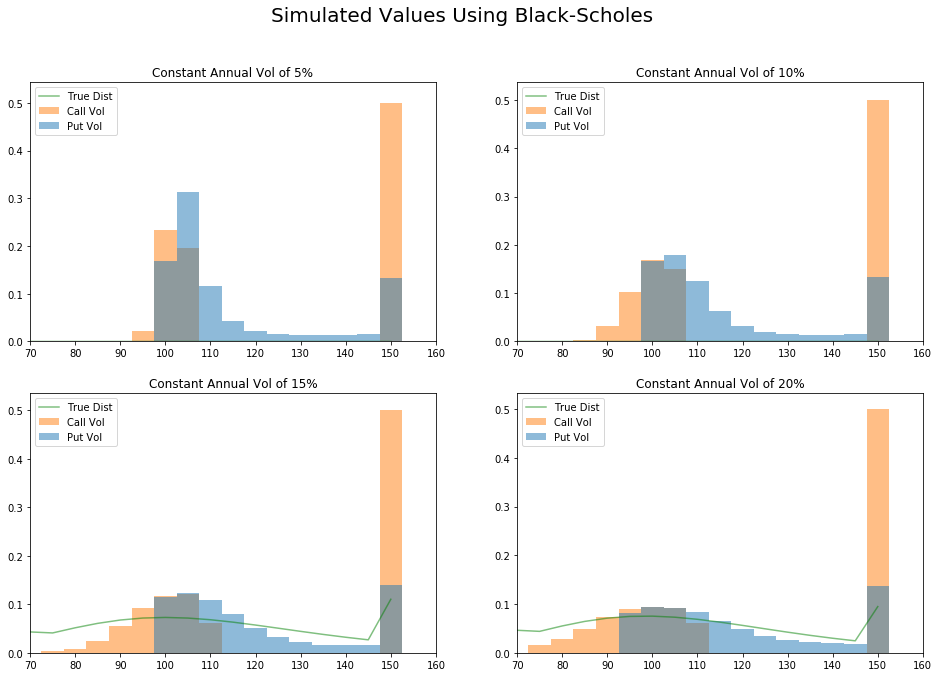

In [ ]:
import scipy.stats as ss
import numpy as np
from scipy import integrate

step_size = 5
plot_t_hist = True
plot_calls = True
plot_puts = True
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(16, 10.5)

fig.suptitle("Simulated Values Using Black-Scholes", fontsize = 20)
for ax,annual_vol in zip((ax1, ax2, ax3, ax4), [0.05,0.1, 0.15, 0.2]):
  stock, call_options, put_options = Euro_Option.make_random_series(step_size = step_size, exp_vol = annual_vol)

  x_axis = np.array([0] + [i.strike for i in call_options]+[np.inf])
  ax.set_title(f"Constant Annual Vol of {int(annual_vol*100)}%")
  if plot_calls:
    ax.bar(x_axis[:-1], Euro_Option.make_prob_dist(call_options), 
            color='tab:orange', label = "Call Vol", alpha = 0.5, width = step_size)#, align='edge')#calls have prob is less
  if plot_puts:
    ax.bar(x_axis[:-1], Euro_Option.make_prob_dist(put_options), 
                color='tab:blue', label = "Put Vol",  alpha = 0.5, width = step_size)#, align = 'edge')

  call_iv = [i.calc_iv() for i in call_options]
  opt = call_options[0]

  target_div = call_iv[len(call_iv)//2]
  exp_ret = stock.exp_dret*opt.lifetime# - 0.5*opt.lifetime*target_div**2#don't account for vol drag since have yearly
  target_dist = ss.lognorm(loc = 0, scale = np.exp(exp_ret), s = target_div*(opt.lifetime**0.5))
  # plt.show()
  if plot_t_hist:#plot a histogram
    # x_axis = np.linspace(x_axis[1]-5, x_axis[-2]+10, 1000)
    target_hist = [integrate.quad(lambda x: target_dist.pdf(x/stock.price0)/stock.price0, i,j)[0] for i,j in zip(x_axis[:-1], x_axis[1:])]
    ax.plot(x_axis[:-1], target_hist, "g",
            label = "True Dist", alpha = 0.5)
  else:#doesn't work
      x_axis = np.linspace(x_axis[1]-5, x_axis[-2]+10, 100)
      print(target_dist.pdf(np.exp(exp_ret)))
      # plt.plot(x_axis, target_dist.pdf(x_axis/stock.price0)/(np.log(stock.price0)*step_size*(1+exp_ret)), "g",
      ax.plot(x_axis, target_dist.pdf(x_axis/stock.price0)/(step_size), "g",
            label = "True Dist", alpha = 0.5)
  ax.legend()
  ax.set_xlim(x_axis[1]-5, x_axis[-2]+10)
  ax.set_ylim(bottom = 0)
fig.show()

possible range is 
[0.025000005420214726, 0.025000000000634664, 0.025000000103235467, 0.02500000000000024, 0.024999999990909724, 0.024999999999999686, 0.02499999989757306, 0.025000000508999625, 0.025000002411301077, 0.0250000000014498, 0.025000018634044656, 0.025000000000051155, 0.025000060235454775, 0.025000096802741744, 0.025000000206895523, 0.0250000146824055] 16 18
17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:283: RuntimeWarning: divide by zero encountered in double_scalars


[0.048317478945350045, 0.050463358779773815, 0.0514110472049078, 0.051294116613445906, 0.05028072225537866, 0.04855144120582788, 0.04628227638567706, 0.04363422418557883, 0.04074752055690645, 0.037739268275331916, 0.03470467007383704, 0.03171593256163652, 0.028828365058932492, 0.0260803050639008, 0.02349761330769895] [1.8119054604506266, 3.9109103054324708, 4.241411394404894, 4.488235203676517, 4.650966808622527, 4.7337655175682185, 4.743933329531898, 4.690679099949724, 4.584096062651975, 4.434364022351501, 4.251322084045038, 4.043781401608656, 3.819758370308555, 3.5860419462863597, 3.3484098963471003]
104.84353307120135 61.339580903236055
104.84353307120135 38.83093817451902 110.31944148050603 38.83093817451902 0.010000000000000002
[[103.58466    107.0912313 ]
 [115.55020137 111.77200781]
 [100.56293386 101.09740285]
 [105.07805358 105.65994901]
 [105.48817018 106.37872124]
 [108.1204737  117.51212175]
 [104.85408653 104.59932416]
 [114.53555567 113.2554502 ]
 [103.84002609 107.524339

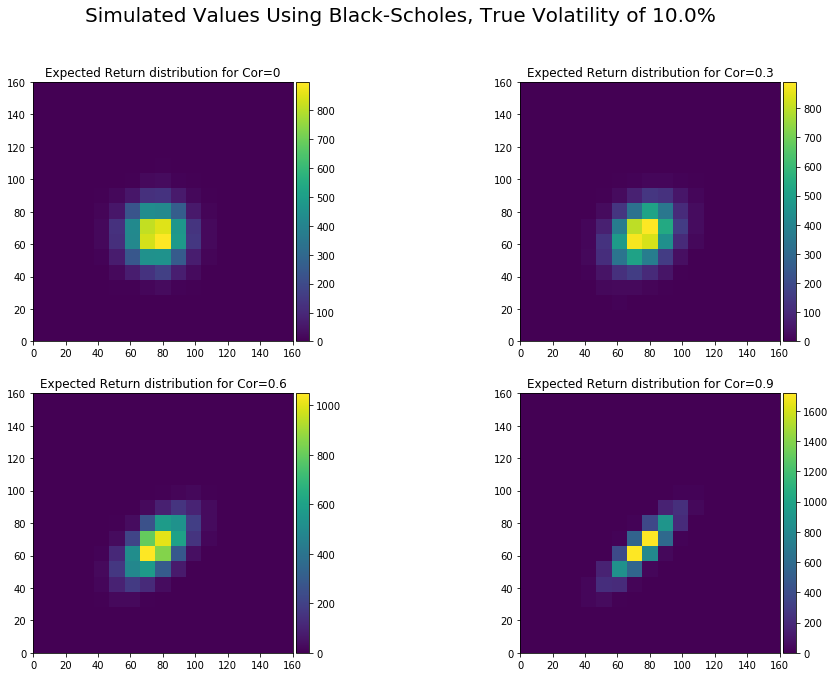

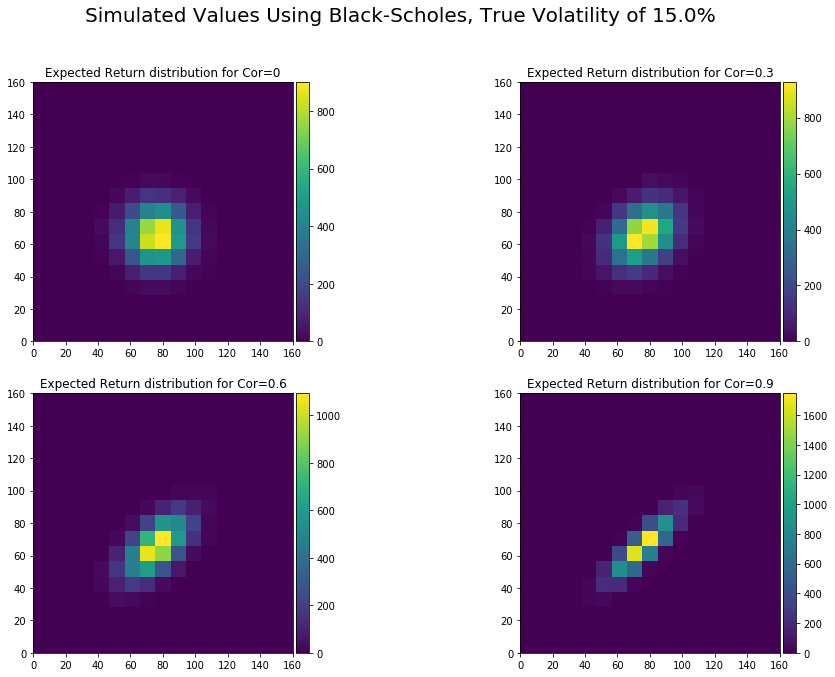

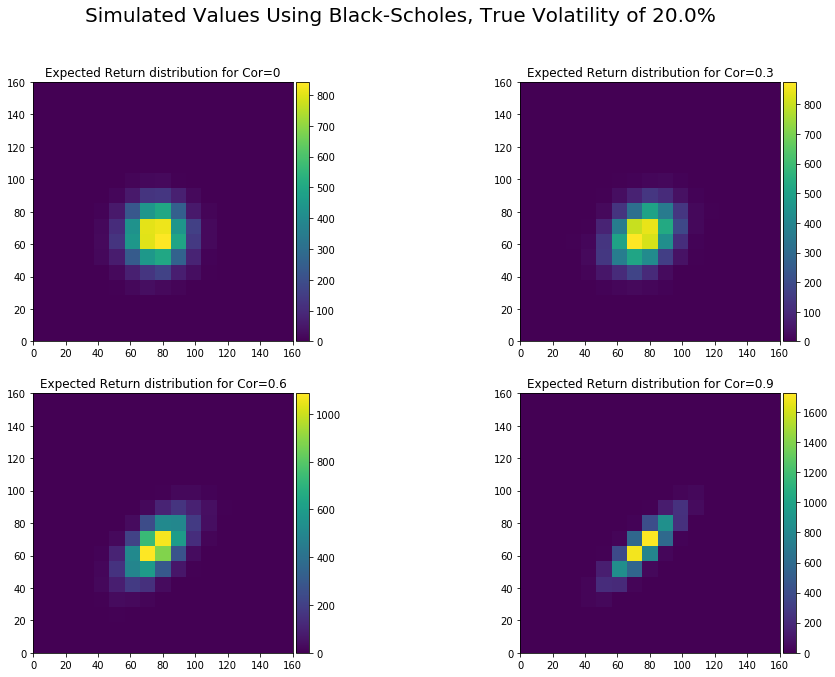

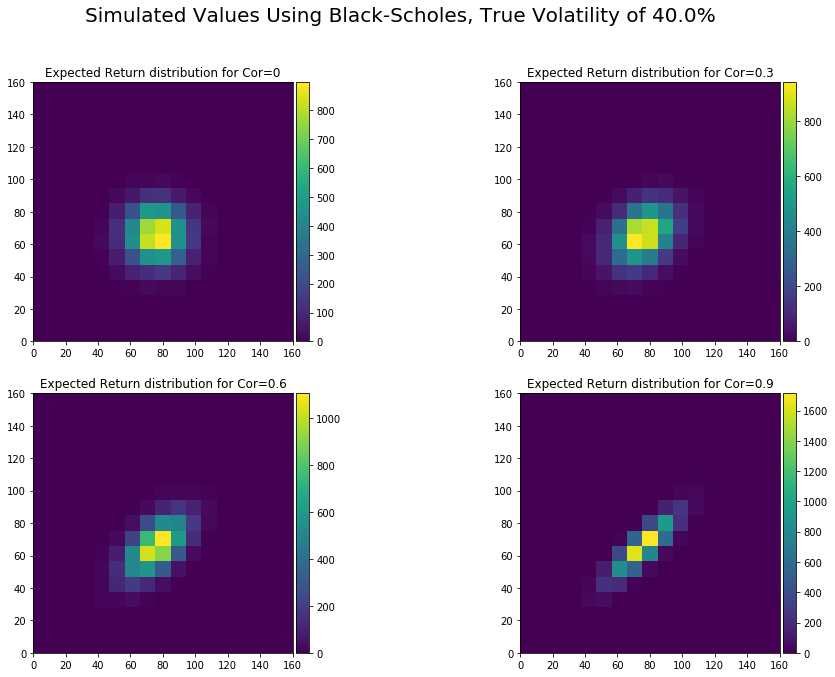

In [ ]:
#simulate Bivariate log-normal
from mpl_toolkits.axes_grid1 import make_axes_locatable

stock, call_options, put_options = Euro_Option.make_random_series(step_size = step_size, exp_vol = annual_vol)
stock2, call_options2, put_options2 = Euro_Option.make_random_series(step_size = step_size, exp_vol = annual_vol)
true_p = 0.5
for annual_vol in [0.1, 0.15, 0.2, 0.4]:
  print("possible range is ")
  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
  fig.set_size_inches(16, 10.5)
  fig.suptitle(f"Simulated Values Using Black-Scholes, True Volatility of {annual_vol*100}%", fontsize = 20)
  for true_p, ax in zip([0, 0.3, 0.6, 0.9], [ax1, ax2, ax3, ax4]):
    lifetime = call_options[0].lifetime
    # exp_ret1 = np.exp(stock.drisk_free*lifetime)
    # exp_ret2 = np.exp(stock2.drisk_free*lifetime)
    exp_ret1 = np.exp(stock.exp_dret*lifetime)
    exp_ret2 = np.exp(stock2.exp_dret*lifetime)

    biggest = call_options[-1].strike + 10#np.infty
    strikes1 = np.array([0] + [i.strike for i in call_options]+[biggest])
    strikes2 = np.array([0] + [i.strike for i in call_options2]+[biggest])

    end_price1 = stock.true_prices[-1]
    out_calls1 = [i for i in call_options if i.strike > end_price1]
    out_puts1 = [i for i in put_options if i.strike <= end_price1]
    end_price2 = stock2.true_prices[-1]
    out_calls2 = [i for i in call_options2 if i.strike > end_price2]
    out_puts2 = [i for i in put_options2 if i.strike <= end_price2]

    iv1 = [i.calc_iv() for i in out_puts1] + [i.calc_iv() for i in out_calls1]
    iv2 = [i.calc_iv() for i in out_puts2] + [i.calc_iv() for i in out_calls2]
    print(iv1, len(iv2), len(strikes1))

    target_dist = ss.lognorm(loc = 0, scale = np.exp(exp_ret), s = target_div*(opt.lifetime**0.5))
    #creates integrates over distribution for the returns
    # discrete1 =  [integrate.quad(lambda x: stock.price0*ss.lognorm.pdf(x/stock.price0, 
    #                                                                    loc = 0,
    #                                                                    scale = exp_ret1, 
    #                                                                    s = iv**2),
    #                              i,
    #                              j)[0]
    #               for i,j, iv in zip(strikes1[:-1], strikes1[1:], iv1)]
    # discrete2 =  [integrate.quad(lambda x: stock2.price0*ss.lognorm.pdf(x/stock2.price0,
    #                                                                     loc = 0,
    #                                                                      scale = exp_ret2, 
    #                                                                      s = iv**2),
    #                              i,
    #                              j)[0]
    #               for i,j, iv in zip(strikes2[:-1], strikes2[1:], iv2)]

    #ignore values outside of strike range
    print(len(Euro_Option.make_prob_dist(call_options)))
    discrete_prob1 =  Euro_Option.make_prob_dist(call_options)[1:-1]
    discrete_prob2 =  Euro_Option.make_prob_dist(call_options2)[1:-1]
    discrete_val1 = [p*(j+i)/2 for (i,j),p in zip(zip(strikes1[:-1], strikes1[1:]), discrete_prob1)]
    discrete_val2 = [p*(j+i)/2 for (i,j),p in zip(zip(strikes2[:-1], strikes2[1:]), discrete_prob2)]

    print(discrete_prob1, discrete_val1)
    # mu1_hat = sum(discrete_val1)#BAD!!, should use CAPM
    # mu2_hat = sum(discrete_val2)
    mu1_hat = stock.price0*exp_ret1#estimate of final price
    mu2_hat = stock2.price0*exp_ret2
    print(mu1_hat, sum(discrete_val1))
    # var1_hat = np.var(discrete1)#/lifetime**0.5
    # var2_hat = np.var(discrete2)#/lifetime**0.5
    #below will be under or over estimate
    var1_hat = sum([p*((i+j)/2)**2 for (i,j),p in zip(zip(strikes1[:-1], strikes1[1:]), discrete_prob1)]) - mu1_hat**2
    var2_hat = sum([p*((i+j)/2)**2 for (i,j),p in zip(zip(strikes2[:-1], strikes2[1:]), discrete_prob2)]) - mu2_hat**2

    var1_hat = (stock.price0*stock.exp_dvol)*lifetime**0.5
    var2_hat = (stock.price0*stock.exp_dvol)*lifetime**0.5

    cov_hat = true_p*var1_hat**0.5*var2_hat**0.5
    print(mu1_hat, var1_hat, mu2_hat, var2_hat, annual_vol**2)

    est_dist = ss.multivariate_normal([mu1_hat, mu2_hat], [[var1_hat, cov_hat],
                                                          [cov_hat, var2_hat]])
    print(est_dist.rvs(10))

    x,y = zip(*est_dist.rvs(10000))
    H, xedges, yedges = np.histogram2d(x, y, bins=(strikes1, strikes2))

    im = ax.imshow(H, interpolation='nearest', origin='low',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    # fig.colorbar(ax=ax)
    # ax.colorbar()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title(f"Expected Return distribution for Cor={true_p}")
    # pcm = ax.pcolormesh(H,
    #                         cmap='viridis')
  # fig.colorbar()#pcm, ax = ax)
  fig.show()
  # call1_probs = Euro_Option.make_prob_dist(call_options)
  # call2_probs = Euro_Option.make_prob_dist(call_options2)
  # lifetime1 = call_options[0].lifetime
  # est_mu1 = sum([e*k for e,k in zip(call1_probs, strikes1)])
  # print(est_mu1, stock.exp_dret, vars(stock), vars(call_options[0]))

possible range is  -0.251684575673842 0.4523552711359932


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:283: RuntimeWarning: divide by zero encountered in double_scalars


[0.012500920679415807, 0.012500014353984871, 0.012500020077225223, 0.012500000252627319, 0.012500005134910546, 0.012500003068724137, 0.012499999999999664, 0.01250000068621116, 0.012500000001049687, 0.01250000110719511, 0.012500083303502415, 0.012500000106271808, 0.012500008187479298, 0.012500182086421344, 0.01250000030246273, 0.012500008856675213] 16 18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:283: RuntimeWarning: overflow encountered in double_scalars


17
[0.028549288737804872, 0.04381429741049234, 0.060048509959264085, 0.0747562151778483, 0.08572747249656004, 0.09160645120298655, 0.09209475830642655, 0.08780999565360503, 0.07994793515722298, 0.06990910086787427, 0.05900275594912974, 0.04827016231832704, 0.03841402781753711, 0.029840524564290427, 0.022684606931607343] [1.0705983276676827, 3.395608049313156, 4.954002071639287, 6.541168828061727, 7.929791205931804, 8.931628992291188, 9.439712726408722, 9.43957453276254, 8.994142705187585, 8.214319351975227, 7.227837603768393, 6.1544456955866975, 5.089858685823668, 4.103072127589933, 3.2325564877540462]
109.71443640165941 94.71831739176167
109.71443640165941 20.31748822252952 109.15899552894503 20.31748822252952 0.04000000000000001
[[110.67361268 104.64302213]
 [109.54742936 108.14850767]
 [114.24725846 103.37074701]
 [104.53724472 105.24184731]
 [110.48084599 104.08617561]
 [111.05256149 102.07602794]
 [120.42455388 114.40742662]
 [109.82990163 101.69082861]
 [106.35442945 110.46654046

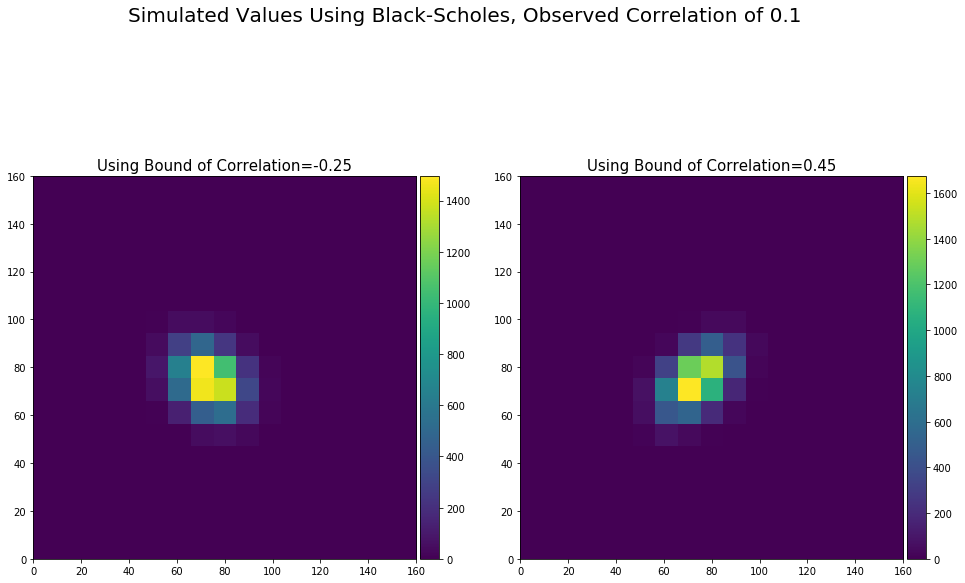

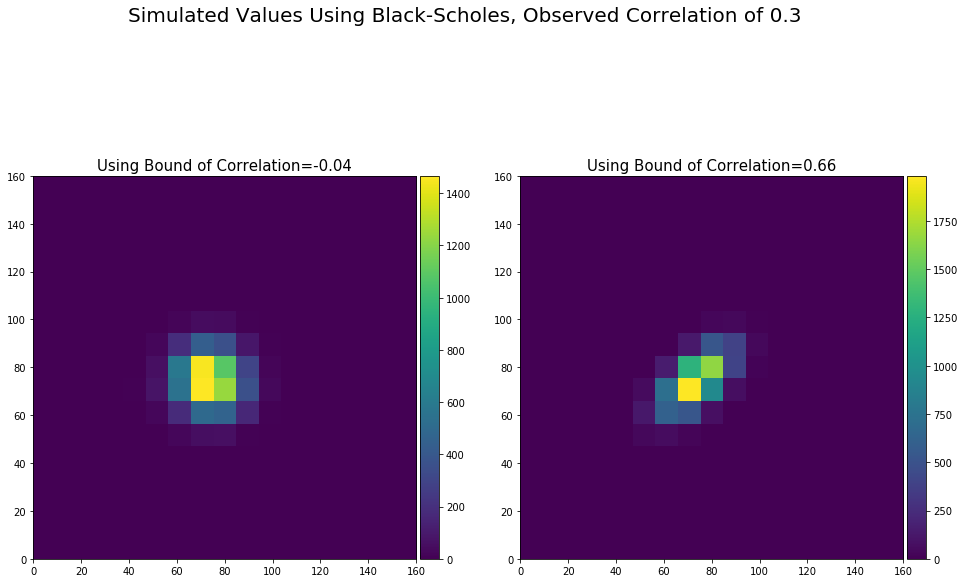

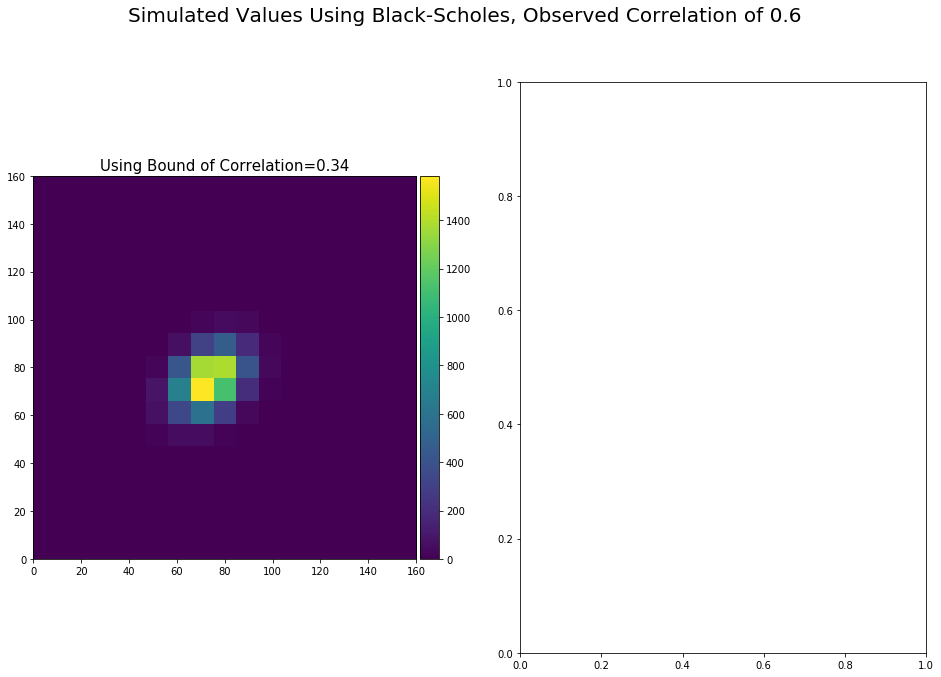

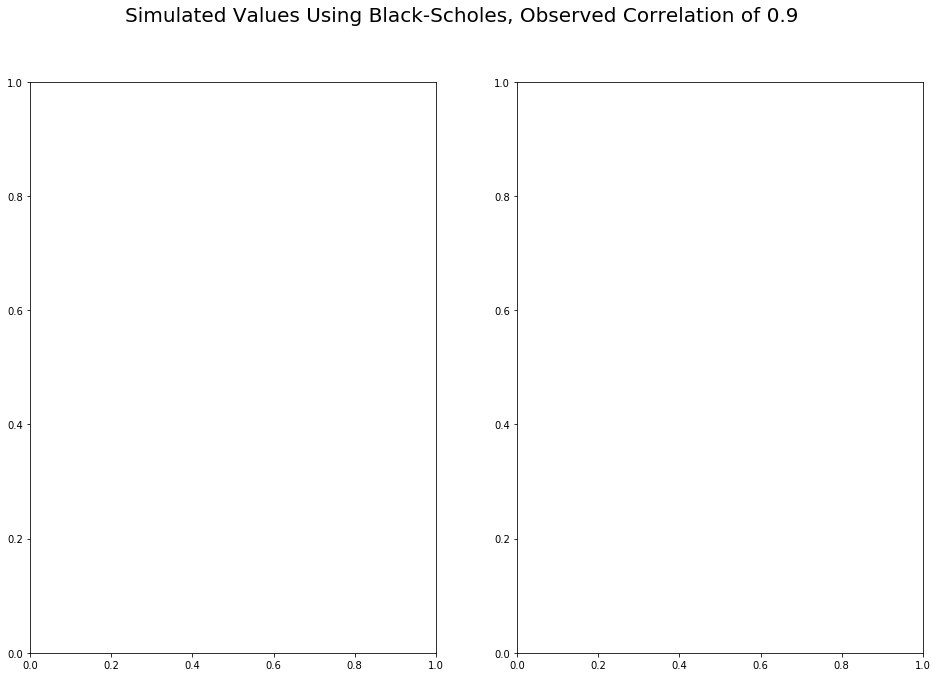

In [ ]:
#Get bounds on Beta

#simulate Bivariate log-normal
from mpl_toolkits.axes_grid1 import make_axes_locatable

stock, call_options, put_options = Euro_Option.make_random_series(step_size = step_size, exp_vol = annual_vol)
stock2, call_options2, put_options2 = Euro_Option.make_random_series(step_size = step_size, exp_vol = annual_vol)
true_p = 0.5
annual_vol = 0.2
for true_p in [0.1, 0.3, 0.6, 0.9]:
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(16, 10.5)
  fig.suptitle(f"Simulated Values Using Black-Scholes, Observed Correlation of {true_p}", fontsize = 20)

  z_critical = ss.norm.ppf(1 - 0.025)
  r = true_p # Pearson's r from sampled data
  z_prime = 0.5 * np.log((1 + r) / (1 - r))
  n = 34 # Sample size
  se = 1 / np.sqrt(n - 3) # Sample standard error
  CI_lower = z_prime - z_critical * se
  CI_upper = z_prime + z_critical * se
  print("possible range is ", CI_lower, CI_upper)
  for true_p, ax in zip([CI_lower, CI_upper], [ax1, ax2]):
    try:  
      lifetime = call_options[0].lifetime
      # exp_ret1 = np.exp(stock.drisk_free*lifetime)
      # exp_ret2 = np.exp(stock2.drisk_free*lifetime)
      exp_ret1 = np.exp(stock.exp_dret*lifetime)
      exp_ret2 = np.exp(stock2.exp_dret*lifetime)

      biggest = call_options[-1].strike + 10#np.infty
      strikes1 = np.array([0] + [i.strike for i in call_options]+[biggest])
      strikes2 = np.array([0] + [i.strike for i in call_options2]+[biggest])

      end_price1 = stock.true_prices[-1]
      out_calls1 = [i for i in call_options if i.strike > end_price1]
      out_puts1 = [i for i in put_options if i.strike <= end_price1]
      end_price2 = stock2.true_prices[-1]
      out_calls2 = [i for i in call_options2 if i.strike > end_price2]
      out_puts2 = [i for i in put_options2 if i.strike <= end_price2]

      iv1 = [i.calc_iv() for i in out_puts1] + [i.calc_iv() for i in out_calls1]
      iv2 = [i.calc_iv() for i in out_puts2] + [i.calc_iv() for i in out_calls2]
      print(iv1, len(iv2), len(strikes1))

      target_dist = ss.lognorm(loc = 0, scale = np.exp(exp_ret), s = target_div*(opt.lifetime**0.5))
      #creates integrates over distribution for the returns
      # discrete1 =  [integrate.quad(lambda x: stock.price0*ss.lognorm.pdf(x/stock.price0, 
      #                                                                    loc = 0,
      #                                                                    scale = exp_ret1, 
      #                                                                    s = iv**2),
      #                              i,
      #                              j)[0]
      #               for i,j, iv in zip(strikes1[:-1], strikes1[1:], iv1)]
      # discrete2 =  [integrate.quad(lambda x: stock2.price0*ss.lognorm.pdf(x/stock2.price0,
      #                                                                     loc = 0,
      #                                                                      scale = exp_ret2, 
      #                                                                      s = iv**2),
      #                              i,
      #                              j)[0]
      #               for i,j, iv in zip(strikes2[:-1], strikes2[1:], iv2)]

      #ignore values outside of strike range
      print(len(Euro_Option.make_prob_dist(call_options)))
      discrete_prob1 =  Euro_Option.make_prob_dist(call_options)[1:-1]
      discrete_prob2 =  Euro_Option.make_prob_dist(call_options2)[1:-1]
      discrete_val1 = [p*(j+i)/2 for (i,j),p in zip(zip(strikes1[:-1], strikes1[1:]), discrete_prob1)]
      discrete_val2 = [p*(j+i)/2 for (i,j),p in zip(zip(strikes2[:-1], strikes2[1:]), discrete_prob2)]

      print(discrete_prob1, discrete_val1)
      # mu1_hat = sum(discrete_val1)#BAD!!, should use CAPM
      # mu2_hat = sum(discrete_val2)
      mu1_hat = stock.price0*exp_ret1#estimate of final price
      mu2_hat = stock2.price0*exp_ret2
      print(mu1_hat, sum(discrete_val1))
      # var1_hat = np.var(discrete1)#/lifetime**0.5
      # var2_hat = np.var(discrete2)#/lifetime**0.5
      #below will be under or over estimate
      var1_hat = sum([p*((i+j)/2)**2 for (i,j),p in zip(zip(strikes1[:-1], strikes1[1:]), discrete_prob1)]) - mu1_hat**2
      var2_hat = sum([p*((i+j)/2)**2 for (i,j),p in zip(zip(strikes2[:-1], strikes2[1:]), discrete_prob2)]) - mu2_hat**2

      var1_hat = (stock.price0*stock.exp_dvol)*lifetime**0.5
      var2_hat = (stock.price0*stock.exp_dvol)*lifetime**0.5

      cov_hat = true_p*var1_hat**0.5*var2_hat**0.5
      print(mu1_hat, var1_hat, mu2_hat, var2_hat, annual_vol**2)

      est_dist = ss.multivariate_normal([mu1_hat, mu2_hat], [[var1_hat, cov_hat],
                                                            [cov_hat, var2_hat]])
      print(est_dist.rvs(10))

      x,y = zip(*est_dist.rvs(10000))
      H, xedges, yedges = np.histogram2d(x, y, bins=(strikes1, strikes2))

      im = ax.imshow(H, interpolation='nearest', origin='low',
              extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
      # fig.colorbar(ax=ax)
      # ax.colorbar()
      divider = make_axes_locatable(ax)
      cax = divider.append_axes('right', size='5%', pad=0.05)
      fig.colorbar(im, cax=cax, orientation='vertical')
      ax.set_title(f"Using Bound of Correlation={true_p:.2f}", fontsize = 15)
      # pcm = ax.pcolormesh(H,
      #                         cmap='viridis')
    # fig.colorbar()#pcm, ax = ax)
    except:
      pass
  fig.show()
  # call1_probs = Euro_Option.make_prob_dist(call_options)
  # call2_probs = Euro_Option.make_prob_dist(call_options2)
  # lifetime1 = call_options[0].lifetime
  # est_mu1 = sum([e*k for e,k in zip(call1_probs, strikes1)])
  # print(est_mu1, stock.exp_dret, vars(stock), vars(call_options[0]))

# Option Types
Calls: The right, but not obligation to buy the "Underlying" at a predetermined price, the "Strike". 

Puts: The right to sell the "Underlying" at the "Strike" of the option. 

You pay a "premium" so your counterparty will give you this privilege.

This privilege is time limited; options have fixed lifetimes 

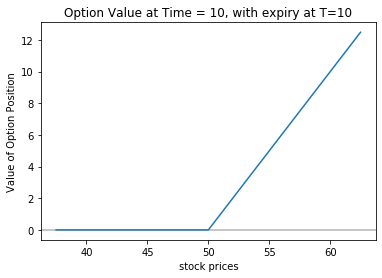

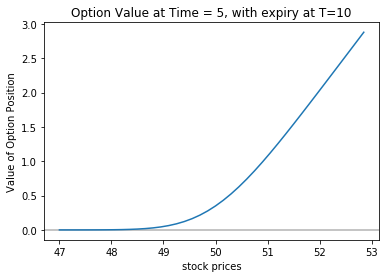

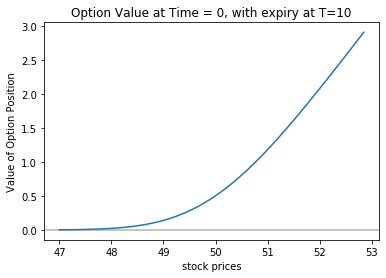

The Greeks
{'Delta': 0.9567570228060056,
 'Gamma': 0.00644567479711804,
 'Rho': 0.047671691833639396,
 'Theta': -0.06450222913163346,
 'Vega': 0.1509404739333614}


In [ ]:
#Calls
# risk_free = 0.05
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    stock = Stock(price0 = 52, exp_vol = 0.12, dividend =0, const =True)
    call1 = Euro_Option(strike = 50, premium = 0, lifetime = 10, tp = 'call', asset = stock)
    call1.make_payoff(position= 'long', t= call1.lifetime, scale = 'auto')
    plt.show()
    call1.make_payoff(position= 'long', t= call1.lifetime//2, scale = 3)
    plt.show()
    call1.make_payoff(position= 'long', scale = 3)
    plt.show()
    print("The Greeks")
pprint(call1.calc_greeks(days_elapsed = 0))
# print(call1.asset.true_prices)

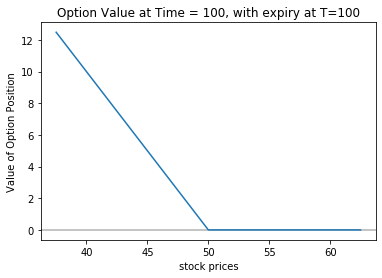

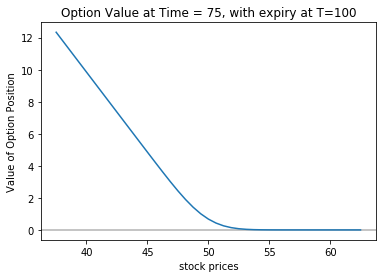

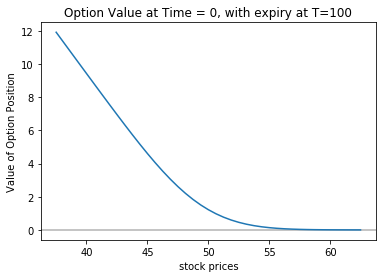

The Greeks:
{'Delta': (-0.5-0.418178158709326j),
 'Gamma': (2.870450600063506e-18-0.025721699444826388j),
 'Rho': (0.06771076162700443+0.059864432490483864j),
 'Theta': (0.018588907603355454+0.021323954525989952j),
 'Vega': (1.7674989518065457e-17+1.6263003009453072j)}


In [ ]:
#Puts
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    put1 = Euro_Option(strike = 50, premium = 0, lifetime = 100, tp = 'put', asset = stock)
    put1.make_payoff(position= 'long', t= put1.lifetime, scale= 'auto')
    plt.show()
    put1.make_payoff(position= 'long', t= put1.lifetime*3//4, scale= 'auto')
    plt.show()
    put1.make_payoff(position= 'long', scale= 'auto')
    plt.show()
    print("The Greeks:")
    pprint(put1.calc_greeks(days_elapsed = 127))


# Option Terms:

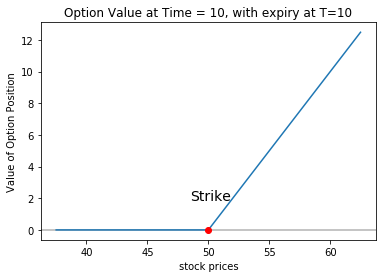

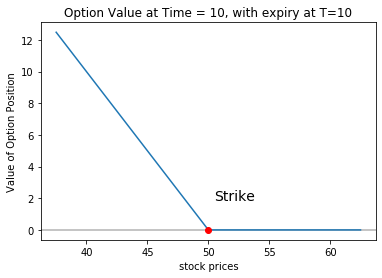

In [ ]:
#strike
import math
def plot_strike(option):
  fig, ax = option.make_payoff(position= 'long', t= option.lifetime, scale= 'auto')
  ax.plot(option.strike, -option.premium, 'ro')
  ymin, ymax = ax.get_ylim()
  x_offset = -1.5 if option.tp=='call' else 0.5
  ax.text(option.strike + x_offset , 2.5 + ymin, "Strike", fontsize=14)
  plt.show()

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    # Temporary rc parameters in effect)
    plot_strike(call1)
    plot_strike(put1)


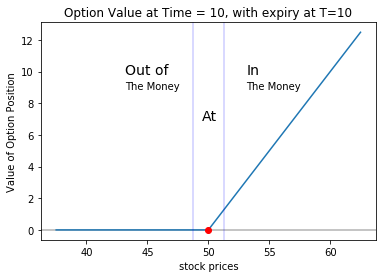

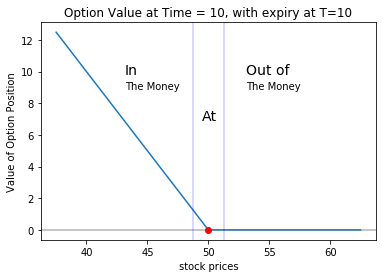

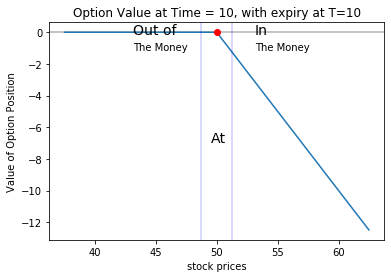

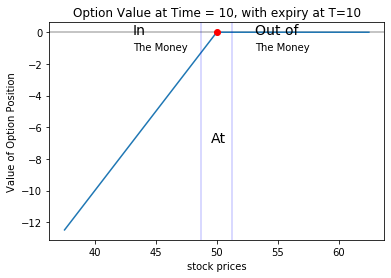

In [ ]:
#At vs. In vs. Out of the Money
def plot_InAtOut(option, pos='long'):
  fig, ax = option.make_payoff(position= pos, t= option.lifetime, scale= 'auto')
  ax.plot(option.strike, option.premium, 'ro')
  ymin, ymax = ax.get_ylim()
  text_ht = (ymax + ymin)/1.8
  xmin, xmax = ax.get_xlim()
  exp_change = option.strike*option.asset.exp_dvol*option.lifetime/3
  lbnd, ubnd = option.strike - exp_change, option.strike + exp_change
  
  ax.axvline(x=lbnd, c='b', alpha=0.2)

  ax.axvline(x=ubnd, c='b', alpha=0.2)
  ax.text(option.strike - 0.5, text_ht, "At", fontsize=14)

  out_xpos, in_xpos = (xmin + option.strike)/2, (xmax + 0.85*option.strike)/2
  #if (option.tp == 'put' and pos == 'long') or (option.tp == 'call' and pos =='short'):
  if option.tp == 'put':
    out_xpos, in_xpos = in_xpos, out_xpos
  #text is ploted above payoff line
  pos_sign = 1 if pos=='long' else -1
  in_ypos = abs(in_xpos - option.strike) * pos_sign 
  out_ypos = abs(out_xpos - option.strike) * pos_sign
  in_ypos, out_ypos = max(in_ypos, out_ypos)+3, max(in_ypos, out_ypos)+3
  ax.text(out_xpos, out_ypos, "Out of", fontsize=14)
  ax.text(out_xpos, out_ypos-1, "The Money", fontsize=10)
  ax.text(in_xpos, in_ypos, "In", fontsize=14)
  ax.text(in_xpos, in_ypos-1, "The Money", fontsize=10)
  plt.show()

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    # Temporary rc parameters in effect)
    plot_InAtOut(call1)
    plot_InAtOut(put1)
    plot_InAtOut(call1, pos='short')
    plot_InAtOut(put1, pos='short')

# Practice Identifying 
Puts vs. Calls, Being Long vs. Short, and the Option's Strike and Premium

67 4.9934558558631394


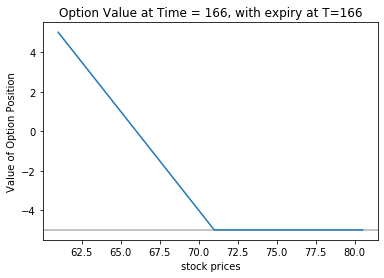

stop?n
{'asset': <__main__.Stock object at 0x7f458e19e9e8>,
 'lifetime': 166,
 'premium': 4.9934558558631394,
 'strike': 71,
 'tp': 'put'}
136 5.236471965517332


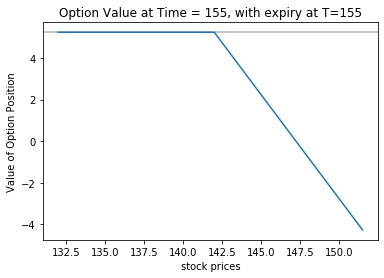

KeyboardInterrupt: ignored

In [ ]:
# Euro_Option.rep_option(long_short = False, at_maturity= True)#Just put vs. call; identify strike, premium
Euro_Option.rep_option(at_maturity = True)#Add Long vs. short Position, Grib!!
# #Add Long vs. short time to expiry/low vs. high implied vol, by commenting out line 180
# Euro_Option.rep_option()

# Greeks
Options sensitive to multiple things. The 'greeks' represent how the option price will react to small changes in these values

Delta: The change in the option's price with a 1$ increase in underlying. First derivative of price.

Gamma: The increase in Delta as the underlying increases. Second derivative of price, always positive.

Vega: Change in the value of the Option with a change in the implied Volatility.

Theta: Change in the Option's price with Time. Always negative.

Rho: Option's value sensitivity to interest rates. (Positive for Calls, Negative for Puts) 

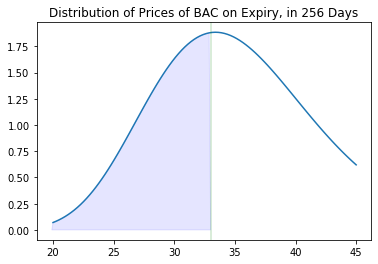

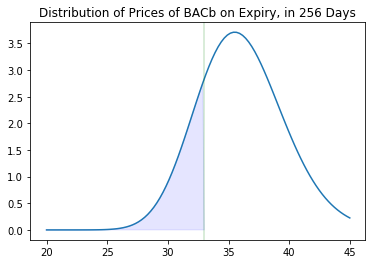

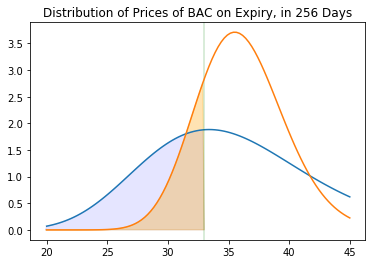

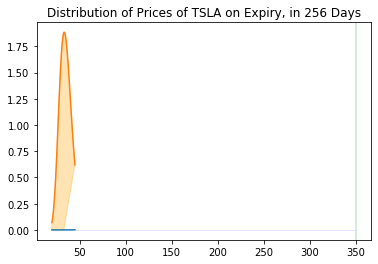

[60.7455131168816, 39.82842221670066, 1.9104904326734768] 2.4846281286518828


In [ ]:
#Future Stock Prices:

import pylab as p
import os
import contextlib
    
def option_shading(option, prices = None, shading = True, option2 = None, print_exp = False):
    "Given an option plot the pay off region for the asset on expiry"
    n = option.lifetime
    lognorm_scale = np.exp(option.asset.ret_dist.kwds['loc']*n)
    lognorm_shape = option.asset.ret_dist.kwds['scale']*(n**0.5)#takes SD
    p0 = option.asset.price0
    total_ret_dist = lognorm(loc = 0, s = lognorm_shape, scale = lognorm_scale)
    if prices is not None:
        price_idx = prices
    else:
        price_idx = np.linspace(p0*max(0,lognorm_scale - 3*lognorm_shape), p0*(lognorm_scale + 3*lognorm_shape), 1000)
    plt.plot(price_idx, total_ret_dist.pdf(price_idx/p0))
#     plt.plot(p0*total_ret_dist.expect(),0, 'ro')#dot at expected value of stock
    plt.title(f"Distribution of Prices of {option.asset.name} on Expiry, in {n} Days")
    plt.axvline(option.strike, color = 'g', alpha = 0.2)
    if option2:
        n2 = option2.lifetime
        lognorm_scale2 = np.exp(option2.asset.ret_dist.kwds['loc']*n2)
        lognorm_shape2 = option2.asset.ret_dist.kwds['scale']*(n2**0.5)#takes SD
        p0_2 = option2.asset.price0
        total_ret_dist2 = lognorm(loc = 0, s = lognorm_shape2, scale = lognorm_scale2)        
        plt.plot(price_idx, total_ret_dist2.pdf(price_idx/p0_2))
    
    if shading:
        #*Note*: EV is still not the option value(but diverges more than expected)
        if option.tp == "put":
            strike_idx = np.concatenate(([price_idx[0] - 0.1], price_idx[price_idx < option.strike], [option.strike]))
        else:
            strike_idx = np.concatenate(([option.strike], price_idx[option.strike < price_idx], [price_idx[-1] + 0.1]))
        p_strike = np.concatenate(([0], total_ret_dist.pdf(strike_idx[1:-1]/p0), [0]))
        p.fill(strike_idx, p_strike, alpha = 0.1, color = 'b')
        if option2 is not None:
            if option2.tp == "put":
                strike_idx2 = np.concatenate(([price_idx[0] - 0.1], 
                                              price_idx[price_idx < option.strike], 
                                              [option2.strike]))
            else:
                strike_idx2 = np.concatenate(([option2.strike],
                                              price_idx[option2.strike < price_idx], 
                                              [price_idx[-1] + 0.1]))
            p_strike2 = np.concatenate(([0], total_ret_dist2.pdf(strike_idx2[1:-1]/p0_2), [0]))
            p.fill(strike_idx2, p_strike2, alpha = 0.3, color = 'Orange')
    if print_exp: 
        if option.tp == "put":
            print(f"Expected Value of Stock 1: {p0*total_ret_dist.expect()}\n",
                    "Expected Value of 'Option' at Expiry is: ", 
                      total_ret_dist.expect(func = lambda i: option.strike - i*p0, 
                                        ub = option.strike/p0))
        else:
            print(f"Expected Value of Stock 1: {p0*total_ret_dist.expect()}\n",
                    "Expected Value of 'Option' at Expiry is: ", 
                      total_ret_dist.expect(func = lambda i: i*p0 - option.strike, 
                                        lb = option.strike/p0))
        if option2 is not None:
            if option2.tp == "put":
                        print(f"Expected Value of Stock 2: {p0_2*total_ret_dist2.expect()}\n",
                            "Expected Value of 'Option' at Expiry is: ", 
                              total_ret_dist.expect(func = lambda i: option2.strike - i*p0_2, 
                                                ub = option2.strike/p0_2))
            else:
                print(f"Expected Value of Stock 2: {p0_2*total_ret_dist2.expect()}\n",
                        "Expected Value of 'Option' at Expiry is: ", 
                          total_ret_dist2.expect(func = lambda i: i*p0_2 - option2.strike, 
                                            lb = option2.strike/p0_2))
    plt.show()#Comment, uncomment this line, grib!!
    
baml = Stock(price0 = 32, exp_vol = 0.2, name = "BAC")
baml_b = Stock(price0 = 33, exp_vol = 0.1, name = "BACb")
tesla = Stock(price0 = 325, exp_vol = 0.497, name = "TSLA")

call1 = Euro_Option(strike = 350, premium = 10, lifetime = 256, tp = 'call', asset = tesla)
call2 = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'call', asset = tesla)
call3 = Euro_Option(strike = 350, premium = 10, lifetime = 4, tp = 'call', asset = tesla)#doesn't match true prices

put1 = Euro_Option(strike = 33, premium = 10, lifetime = 256, tp = 'put', asset = baml)
put1b = Euro_Option(strike = 33, premium = 10, lifetime = 256, tp = 'put', asset = baml_b)

# option_shading(call1, prices = np.linspace(0,1000, 10000))
# option_shading(call2, prices = np.linspace(0,1000, 10000))
# option_shading(call3, prices = np.linspace(0,1000, 10000))
option_shading(put1, prices = np.linspace(20,45,100))
option_shading(put1b, prices = np.linspace(20,45,100))
option_shading(put1, option2 = put1b, prices = np.linspace(20,45,100), print_exp = False)
option_shading(call1, option2 = put1, prices = np.linspace(20,45,100), print_exp = False)

print([op.calc_value(tesla.price0) for op in [call1, call2, call3]], 
      put1.calc_value(baml.price0))

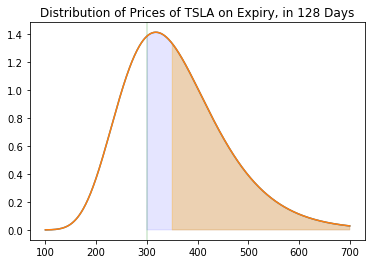

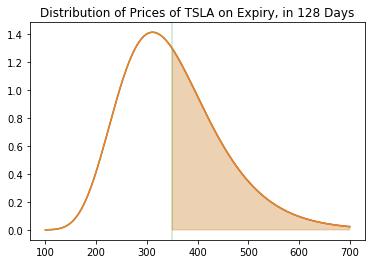

{'Delta': 0.47076458087956735, 'Gamma': 0.0006853288926205469, 'Vega': 14.608802221769185, 'Theta': -0.18317045559315193, 'Rho': 1.59288614939434}


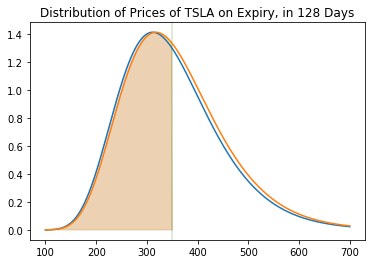


Delta In-the-Money


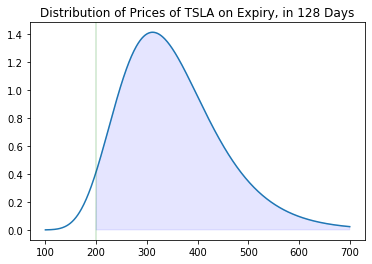

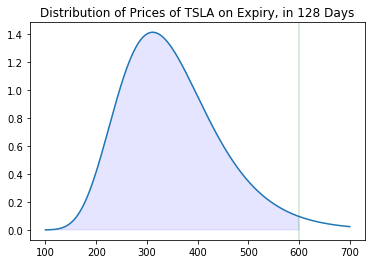


Delta out of the money


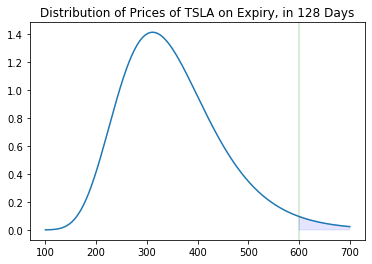

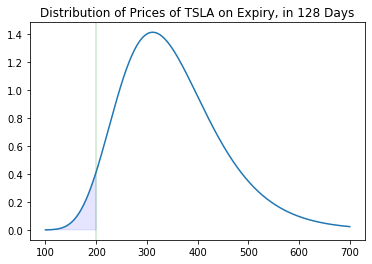

In [ ]:
#Delta Intuition
tesla = Stock(price0 = 325, exp_vol = 0.4, name = "TSLA")
call1 = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'call', asset = tesla)
tesla_p = Stock(price0 = 350, exp_vol = 0.4, name = "TSLA")
call2 = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'call', asset = tesla_p)
call3 = Euro_Option(strike = 300, premium = 10, lifetime = 128, tp = 'call', asset = tesla)
#Shows change in distribution
option_shading(call3, prices = np.linspace(100, 700, 500), option2 = call1)

#Shows delta < 1
put2 = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'put', asset = tesla_p)
option_shading(call2, prices = np.linspace(100, 700, 500), option2 = call2, print_exp = False)
print(call2.calc_greeks())

#Put Intuition
put1 = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'put', asset = tesla)
option_shading(put2, prices = np.linspace(100, 700, 500), option2 = put1)#but delta < 1

print("\nDelta In-the-Money")
call3 = Euro_Option(strike = 200, premium = 10, lifetime = 128, tp = 'call', asset = tesla_p)
option_shading(call3, prices = np.linspace(100, 700, 500))
put4 = Euro_Option(strike = 600, premium = 10, lifetime = 128, tp = 'put', asset = tesla_p)
option_shading(put4, prices = np.linspace(100, 700, 500))
# option_shading(call3, prices = np.linspace(100, 700, 500))

print("\nDelta out of the money")
call4 = Euro_Option(strike = 600, premium = 10, lifetime = 128, tp = 'call', asset = tesla_p)
option_shading(call4, prices = np.linspace(100, 700, 500))
put3 = Euro_Option(strike = 200, premium = 10, lifetime = 128, tp = 'put', asset = tesla_p)
option_shading(put3, prices = np.linspace(100, 700, 500))
# option_shading(call4, prices = np.linspace(100, 700, 500))


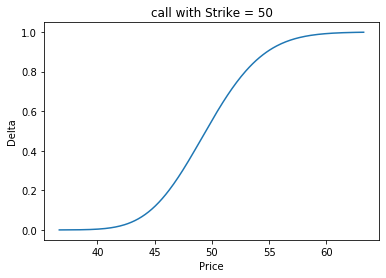

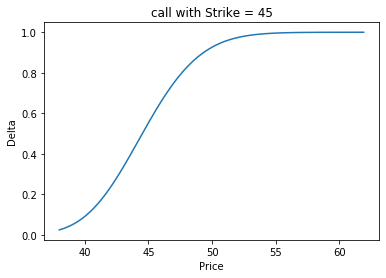

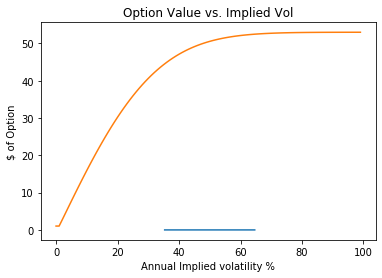

In [ ]:
#Call Delta
call1 = Euro_Option(strike = 50, premium = 0, lifetime = 64, tp = 'call')
a = Euro_Option.plot_greek(call1, x_axis = 'Price')
a.show()
call1.strike = 45
a = Euro_Option.plot_greek(call1, x_axis = 'Price')
a.show()
call1.strike = 55
a = Euro_Option.plot_greek(call1, x_axis = 'Price', greek='gamma')
a.show()
#grib delete
# iv = list(range(100)) 
# val = [call1.calc_value(spot = 53, iv = i/100) for i in iv]
# with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
#   # print(iv, val, a.calc_value(spot=50, iv = 10))
#   plt.plot(iv, val)
#   plt.xlabel("Annual Implied volatility %")
#   plt.ylabel("$ of Option")
#   plt.title("Option Value vs. Implied Vol")
#   plt.show()

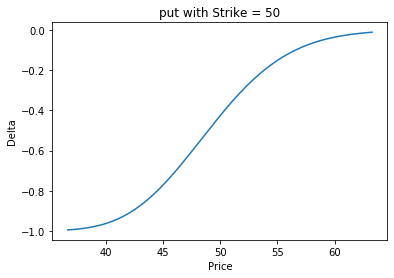

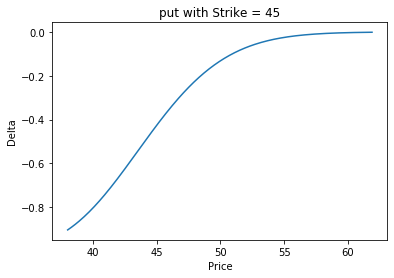

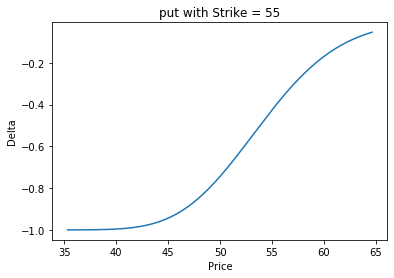

In [ ]:
#Put Delta
put1 = Euro_Option(strike = 50, premium = 10, lifetime = 128, tp = 'put')
a = Euro_Option.plot_greek(put1, x_axis = 'Price')
a.show()
put1.strike = 45
a = Euro_Option.plot_greek(put1, x_axis = 'Price')
a.show()
put1.strike = 55
a = Euro_Option.plot_greek(put1, x_axis = 'Price')
a.show()
# print(put1.strike, put1.asset.true_prices)

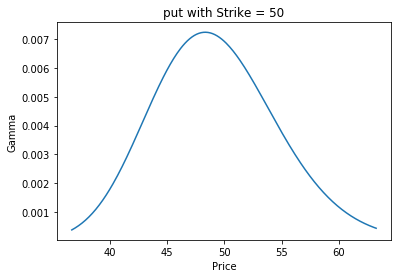

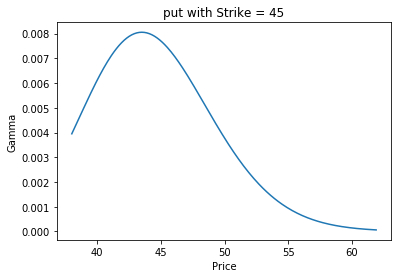

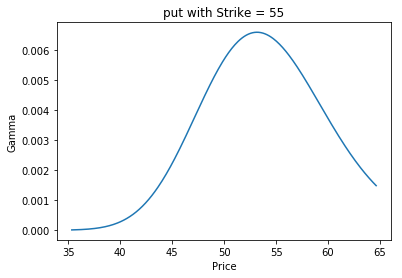

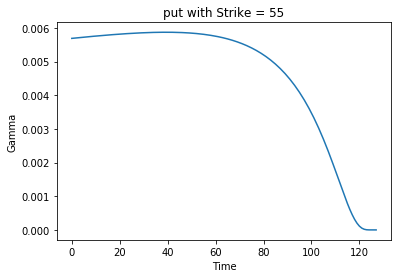

In [ ]:
#Call Gamma
call1.strike = 50
a = Euro_Option.plot_greek(call1, greek='Gamma', x_axis = 'Price')
a.show()
call1.strike = 45
a = Euro_Option.plot_greek(call1, greek='Gamma',x_axis = 'Price')
a.show()
call1.strike = 55
a = Euro_Option.plot_greek(call1,greek='Gamma', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(call1,greek='Gamma', x_axis = 'Time')
b.show()

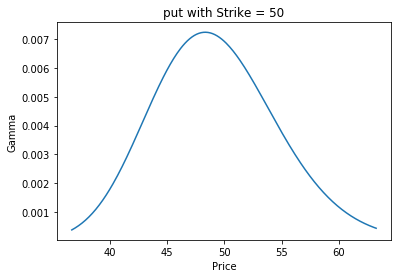

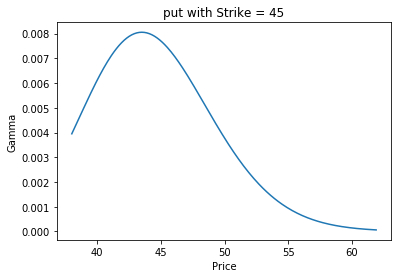

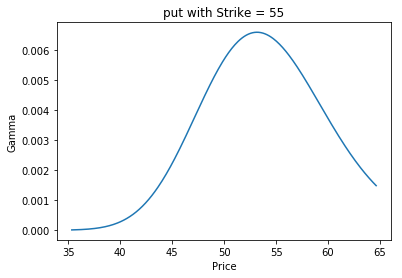

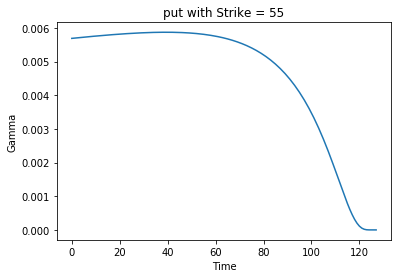

In [ ]:
#Put Gamma
put1 = Euro_Option(strike = 50, premium = 10, lifetime = 128, tp = 'put')
a = Euro_Option.plot_greek(put1, greek='Gamma',x_axis = 'Price')
a.show()
put1.strike = 45
a = Euro_Option.plot_greek(put1, greek='Gamma', x_axis = 'Price')
a.show()
put1.strike = 55
a = Euro_Option.plot_greek(put1, greek='Gamma', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(put1,greek='Gamma', x_axis = 'Time')
b.show()


 Vega when In-the-Money


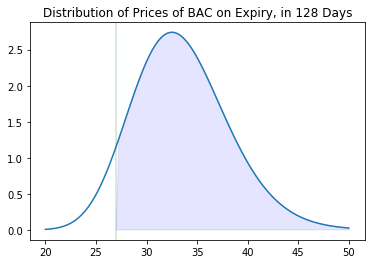

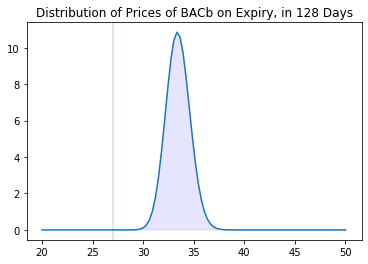


 Vega when Out of the money


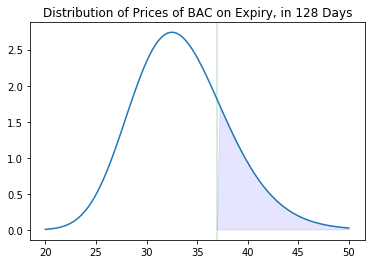

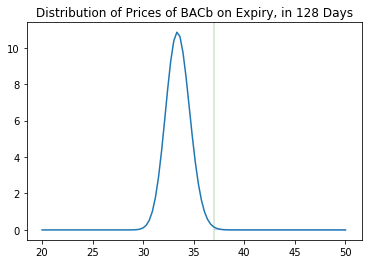


 Vega when at the money


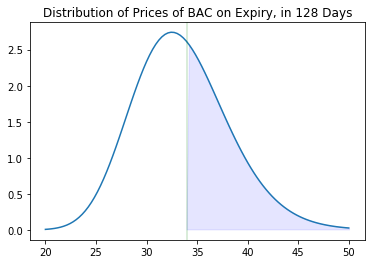

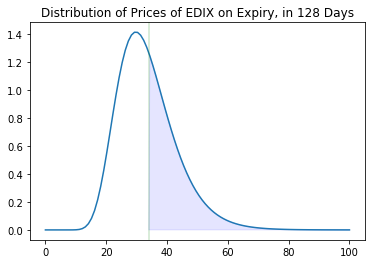

In [ ]:
#Vega Intuition
baml = Stock(price0 = 32, exp_vol = 0.2, name = "BAC")
baml_b = Stock(price0 = 32, exp_vol = 0.05, name = "BACb")
risky = Stock(price0 = 32, exp_vol = 0.4, name = "EDIX")

print("\n Vega when In-the-Money")
#When in the money, the vega of an option is lower
call5 = Euro_Option(strike = 27, premium = 10, lifetime = 128, tp = 'call', asset = baml)
call6 = Euro_Option(strike = 27, premium = 10, lifetime = 128, tp = 'call', asset = baml_b)
option_shading(call5, prices = np.linspace(20, 50, 100))
# option_shading(call6, prices = np.linspace(20, 50, 100), option2 =call5)#vega increases
option_shading(call6, prices = np.linspace(20, 50, 100))

print("\n Vega when Out of the money")
#When Near the money, vega higher
call5.strike = 37#out
call6.strike = 37
option_shading(call5, prices = np.linspace(20, 50, 100))
option_shading(call6, prices = np.linspace(20, 50, 100))

print("\n Vega when at the money")
call5.strike = 34#near
option_shading(call5, prices = np.linspace(20, 50, 100))
call7 = Euro_Option(strike = 34, premium = 10, lifetime = 128, tp = 'call', asset = risky)
option_shading(call7, prices = np.linspace(0, 100, 100))


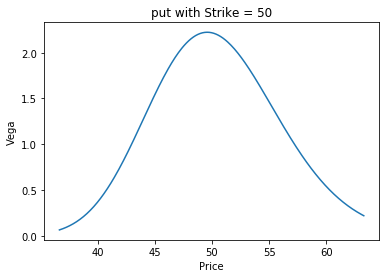

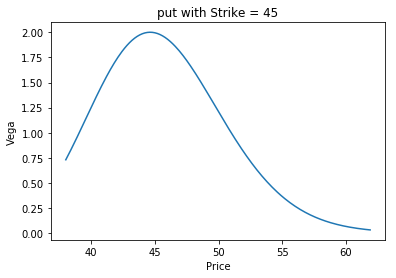

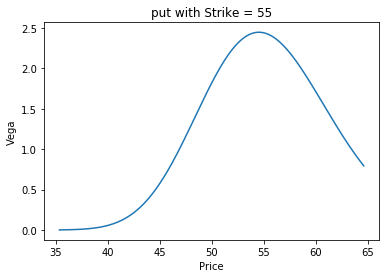

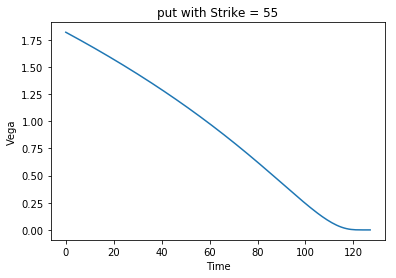

In [ ]:
#Call Vega
call1.strike = 50
a = Euro_Option.plot_greek(call1, greek='Vega', x_axis = 'Price')
a.show()
call1.strike = 45
a = Euro_Option.plot_greek(call1, greek='Vega',x_axis = 'Price')
a.show()
call1.strike = 55
a = Euro_Option.plot_greek(call1,greek='Vega', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(call1,greek='Vega', x_axis = 'Time')
b.show()

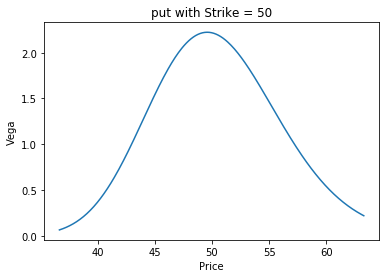

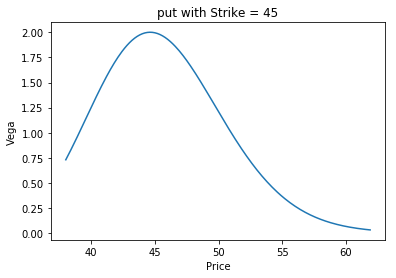

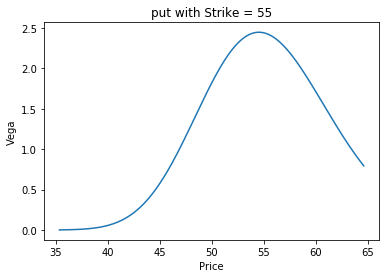

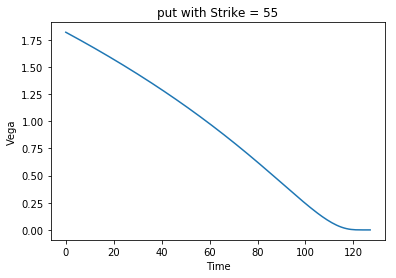

In [ ]:
#Put Vega
put1 = Euro_Option(strike = 50, premium = 10, lifetime = 128, tp = 'put')
a = Euro_Option.plot_greek(put1, greek='Vega',x_axis = 'Price')
a.show()
put1.strike = 45
a = Euro_Option.plot_greek(put1, greek='Vega', x_axis = 'Price')
a.show()
put1.strike = 55
a = Euro_Option.plot_greek(put1, greek='Vega', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(put1,greek='Vega', x_axis = 'Time')
b.show()

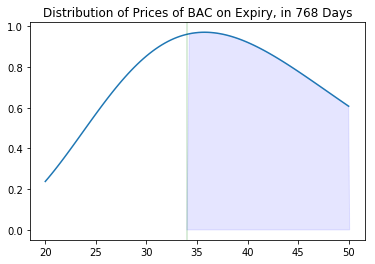

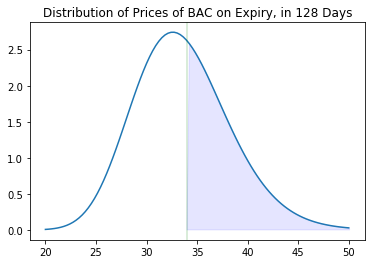

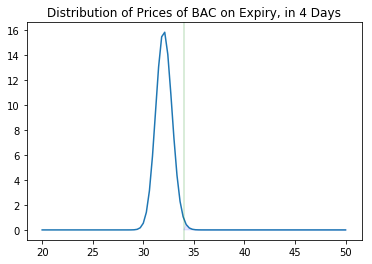

In [ ]:
#Theta Intutition: Inverse of Vega but with more Time to grow. Less chance to realize Vol.
call5.lifetime = 768#3 years
option_shading(call5, prices = np.linspace(20, 50, 100))
call5.lifetime = 128#1/2 year
option_shading(call5, prices = np.linspace(20, 50, 100))
call5.lifetime = 4#1/2 year
option_shading(call5, prices = np.linspace(20, 50, 100))

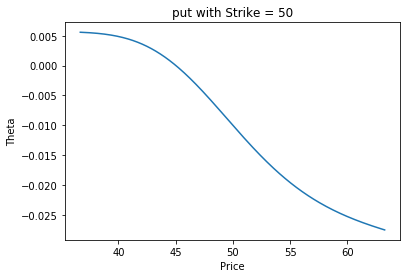

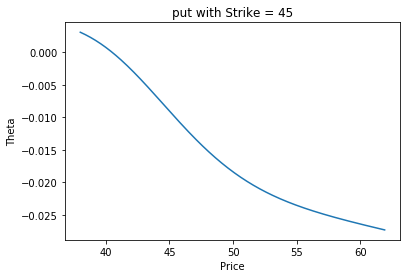

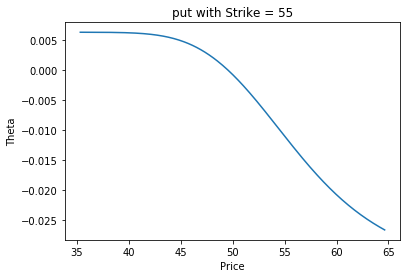

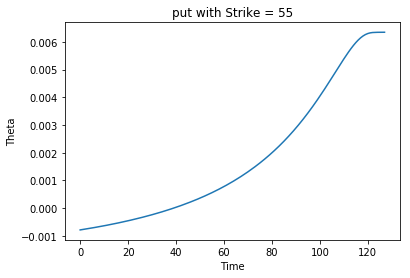

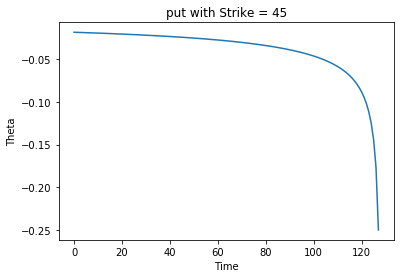

In [ ]:
#Call Theta
call1.strike = 50
a = Euro_Option.plot_greek(call1, greek='Theta', x_axis = 'Price')
a.show()
call1.strike = 45
a = Euro_Option.plot_greek(call1, greek='Theta',x_axis = 'Price')
a.show()
call1.strike = 55
a = Euro_Option.plot_greek(call1,greek='Theta', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(call1,greek='Theta', x_axis = 'Time')
b.show()
call1.strike = 45
b = Euro_Option.plot_greek(call1,greek='Theta', x_axis = 'Time')
b.show()

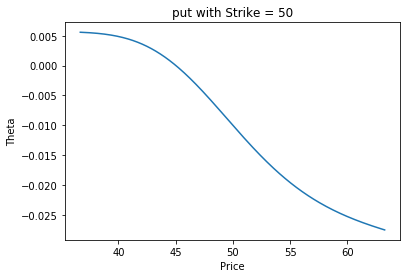

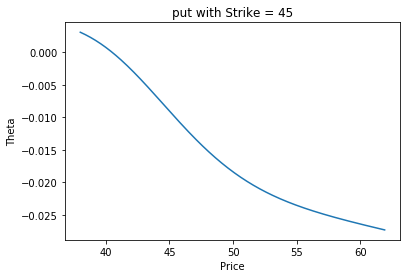

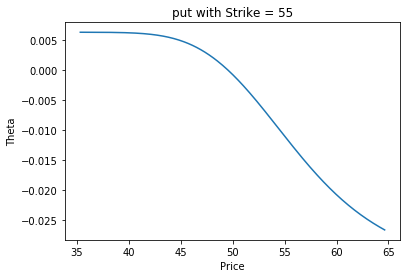

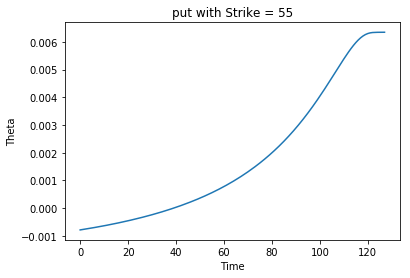

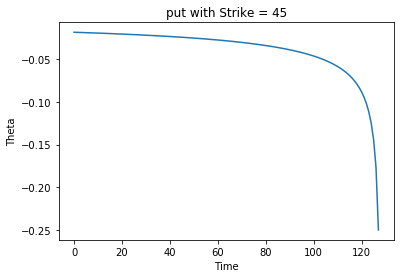

In [ ]:
#Put Theta
put1 = Euro_Option(strike = 50, premium = 10, lifetime = 128, tp = 'put')
a = Euro_Option.plot_greek(put1, greek='Theta',x_axis = 'Price')
a.show()
put1.strike = 45
a = Euro_Option.plot_greek(put1, greek='Theta', x_axis = 'Price')
a.show()
put1.strike = 55
a = Euro_Option.plot_greek(put1, greek='Theta', x_axis = 'Price')
a.show()
b = Euro_Option.plot_greek(put1, greek='Theta', x_axis = 'Time')
b.show()
put1.strike = 45
b = Euro_Option.plot_greek(put1, greek='Theta', x_axis = 'Time')
b.show()

# Value = Time Value + Instrinsic Value
There's 2 components of option value, the Instrinsic value(Value if excersised today) and Time Value(Value it might go up).

Theta is the decrease in Timve Value

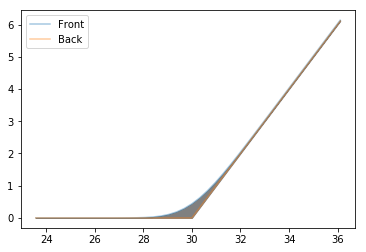

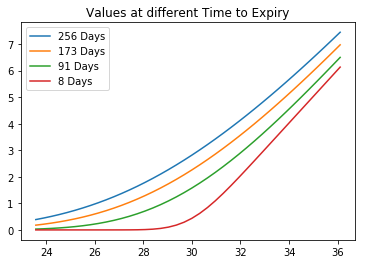

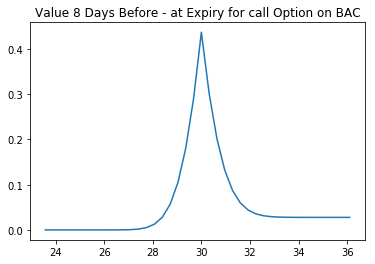

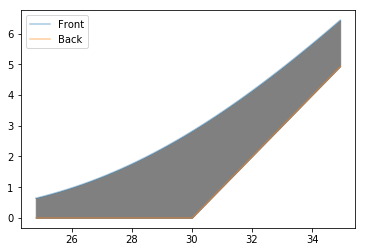

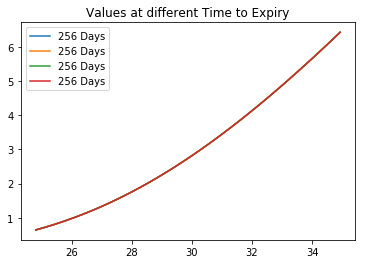

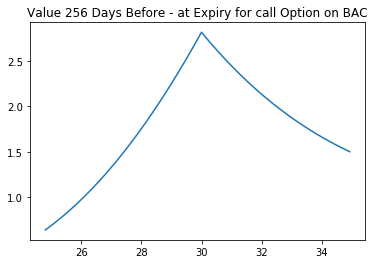

In [ ]:
def plot_time_val(option, x_axis = None, t= 0):
    "Plot Differnce in value at Present vs. Expiry"
    vol = option.asset.exp_vol
    scale = vol*option.asset.true_prices[t] or 10#sets as 2SD for year
    x_axis = x_axis or np.arange(option.strike - scale, option.strike + scale, scale/20)
    val = [option.calc_value(spot = i, days_elapsed=option.lifetime - t)  for i in x_axis]
    intrinsic = [option.calc_value(spot = i, days_elapsed=option.lifetime) for i in x_axis]
    time_val = [i-j for i,j in zip(val, intrinsic)]
    plt.plot(x_axis, val, alpha = 0.4)
    plt.plot(x_axis, intrinsic, alpha = 0.4)
    plt.fill_between(x_axis, intrinsic, val, color = 'grey')
    plt.legend(("Front", "Back"))
    plt.show()
    plt.title("Values at different Time to Expiry")
#     plt.legend([for i in np.linspace(0, option.lifetime - t, 4)])
    for e in np.linspace(0, option.lifetime - t, 4):
        val = [option.calc_value(spot = i, days_elapsed=e)  for i in x_axis]
        plt.plot(x_axis, val, label = f"{option.lifetime - e:.0f} Days" )
    plt.legend()
    plt.show()
    plt.plot(x_axis, time_val)
    plt.title(f"Value {t} Days Before - at Expiry for {option.tp} Option on {option.asset.name}")
    plt.show()
    
    
call_option = Euro_Option(strike = 30, premium = 0, lifetime = 256, tp = 'call', asset = baml)
put_option = Euro_Option(strike = 30, premium = 0, lifetime = 256, tp = 'put', asset = baml)
for o in [call_option]:#, put_option]:
    for t in [8, 256]:
        plot_time_val(o, t= t)

# Hedging
Greeks are additive: if have a position with a delta of 0.8, vega of 0.5 and theta of 0.1, and the price goes up by 1/2 a dollar tommorow, but the implied vol drops by 2pts then what's the change in position?  0.8 \* 0.5 -0.5\*2+0.1\*1 = \$ 0.5 dollars.

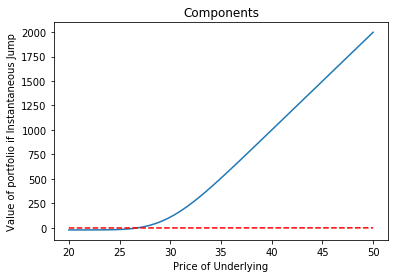

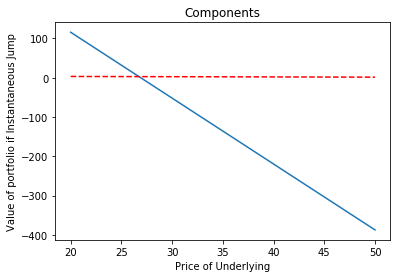

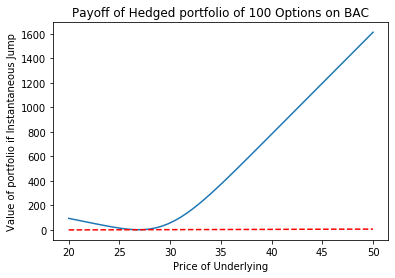

In [ ]:
def option_stock_graph(option, stock, position = 100, price0 = 25, x_axis = np.linspace(15,50), 
                       days_elapsed = 0, zero_line = False, tangent = False, seperate = False, show =True, offset = 0):
    d_hedge = option.calc_greeks(spot = price0, days_elapsed = days_elapsed)['Delta']
    instr = [option, stock]
    weights = [position, -position*d_hedge]
    kwarg_lst = [{'days_elapsed': days_elapsed}, {'spot':price0}]
    if seperate:
        for i,j,k in zip(instr, weights, kwarg_lst):
            plot_port_payoff([i],[j],[k], x_axis, tangent = tangent, price0 = price0)
            plt.title("Components")
            plt.show()
    plot_port_payoff(instr, weights, kwarg_lst, x_axis, 
                     tangent = tangent, price0 = price0,
                     zero_line = zero_line, offset = offset)
    plt.title(f"Payoff of Hedged portfolio of {position} Options on {stock.name}")
    if show:
        plt.show()
    
p0 = baml.price0    
call_option = Euro_Option(strike = 30, premium = 0, lifetime = 128, tp = 'call', asset = baml)
put_option = Euro_Option(strike = 30, premium = 0, lifetime = 128, tp = 'put', asset = baml)
x_axis = np.linspace(20,50)

#First 2 are long, 2nd 2 are Short
option_stock_graph(call_option, baml, tangent = True, x_axis = x_axis, price0 =p0-5,days_elapsed = 64, seperate = True)
# option_stock_graph(put_option, baml, tangent = True, x_axis = x_axis, price0 =p0)
# option_stock_graph(call_option, baml, position = -100,  tangent = True, x_axis = x_axis, price0 =p0)
# option_stock_graph(put_option, baml, position = -100, days_elapsed = 100, tangent = True, x_axis = x_axis, price0 =p0)



Option Vol is underestimatted, BUY


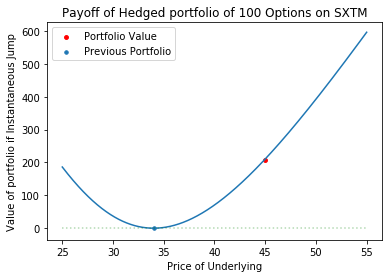

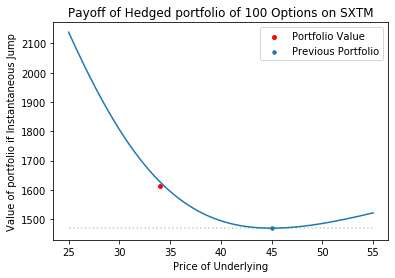

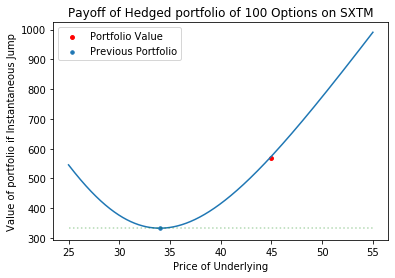

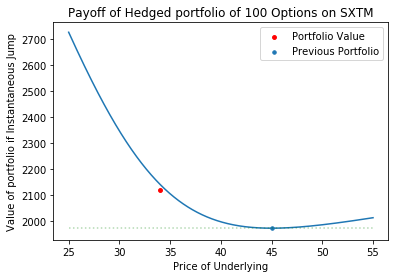

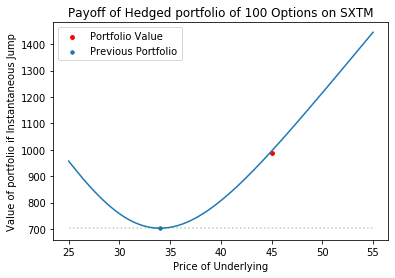

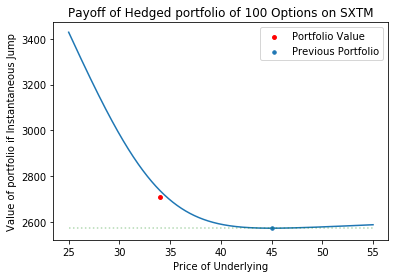

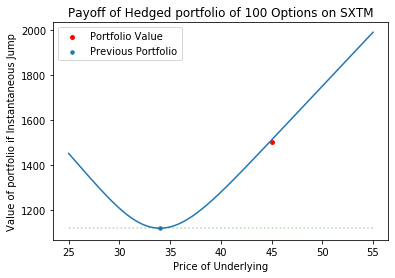

Option Vol is overestimated, SELL
Option Value:  3399.9998709306005
Initial Portfolio Value: -6.453562900787801e-05 [100, -99.99999810194792]
Theta Bill, value change due to passage of time: -0.0007812052599547314
Gamma Scalping return: Gain from prices changing Instantly:  -0.00011570432661756058
Total Return since previous:  -0.000896909586572292


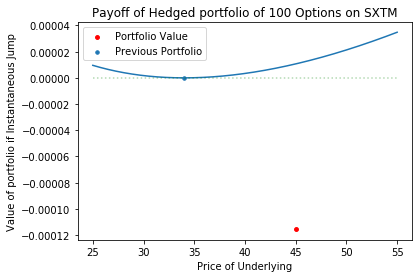

New Portfolio Value:  -0.0005260296857159119 profit -0.0008969095868991417 [100, -99.99998842604725] 

Theta Bill, value change due to passage of time: -0.006403063485777238
Gamma Scalping return: Gain from prices changing Instantly:  0.0008443239121334045
Total Return since previous:  -0.005558739573643834


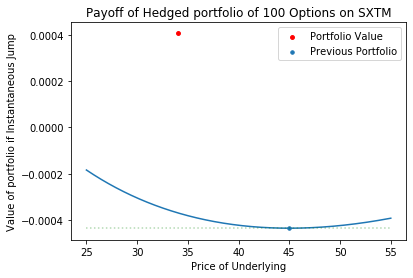

New Portfolio Value:  -0.0032391876579822565 profit -0.00555873957324593 [100, -99.99990473247075] 

Theta Bill, value change due to passage of time: -0.04019095635794656
Gamma Scalping return: Gain from prices changing Instantly:  -0.005947715217644145
Total Return since previous:  -0.046138671575590706


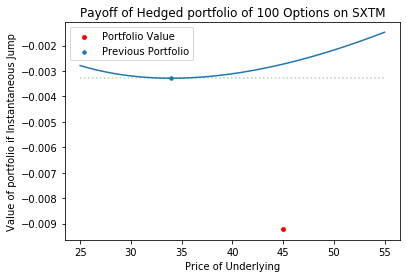

New Portfolio Value:  -0.02701477379196149 profit -0.04613867157567597 [100, -99.9994077750165] 

Theta Bill, value change due to passage of time: -0.33959890012010874
Gamma Scalping return: Gain from prices changing Instantly:  0.04471378343896504
Total Return since previous:  -0.2948851166811437


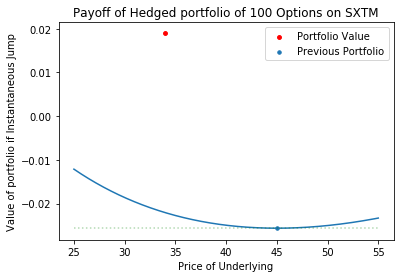

New Portfolio Value:  -0.1710201146511281 profit -0.2948851166807458 [100, -99.99497013455115] 

Theta Bill, value change due to passage of time: -2.2313971191883866
Gamma Scalping return: Gain from prices changing Instantly:  -0.32959634305098007
Total Return since previous:  -2.5609934622393666


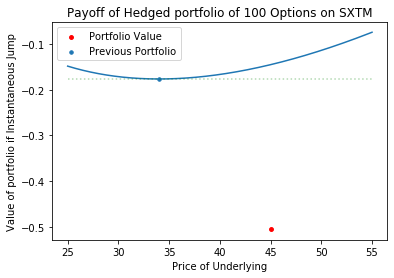

New Portfolio Value:  -1.4951471189215226 profit -2.560993462238912 [100, -99.96748421326296] 

Theta Bill, value change due to passage of time: -20.32461924186464
Gamma Scalping return: Gain from prices changing Instantly:  2.6652525692734343
Total Return since previous:  -17.659366672591204


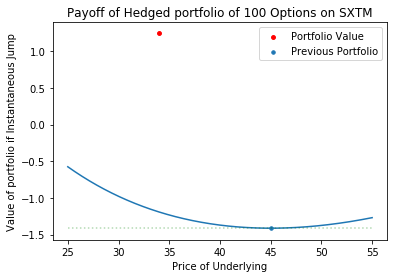

New Portfolio Value:  -10.130153623223578 profit -17.659366672591148 [100, -99.70206185537211] 

Theta Bill, value change due to passage of time: -155.95152859615928
Gamma Scalping return: Gain from prices changing Instantly:  -22.844634523878085
Total Return since previous:  -178.79616312003736


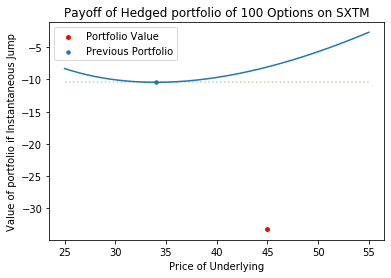

New Portfolio Value:  -103.93578559198613 profit -178.79616312003714 [100, -97.81338338534378] 

Total Hedging Return:  -1299.36398331986


In [ ]:
import os
import contextlib 
def hedge_ex(option, x_axis):
    "Plots an Example hedging With Postion=Long"
    prev = option.asset.true_prices[0]
    print("Starting Option Value: ", 100*option.calc_value(spot = prev))
    instr = [option, stock_ex]
    d_hedge = option.calc_greeks(spot = prev, days_elapsed = 0)['Delta']
    initial_hedge = prev*d_hedge*100
    cash_position = initial_hedge
    weights = [100, -100*d_hedge]
    kwarg_lst = [{'days_elapsed': 0, 'spot':prev}, {'spot':prev}]
    prev_value = portfolio_value(instr, weights, kwarg_lst)
    print(f"Initial Portfolio Value: ${prev_value} = {weights[0]} options and {wegihts[1]} shares")
    gamma_sum = 0
    theta_sum = 0
    for e, p in enumerate(option.asset.true_prices[1:]):
        #Hedged at previous prices, make profit from that change
        e += 1
        #Theta bill: change between previous and now, assuming prices from constant at last
        kwarg_lst = [{'days_elapsed': e, 'spot':prev}, {'spot':prev}]
        value = portfolio_value(instr, weights, kwarg_lst)#value of portfolio today if stock didn't move
        print("Theta Bill, value change due to passage of time:", value - prev_value)
        theta_sum += value - prev_value

        #Gamma Scalping: Return from stock price changing, 'instantaneously' today
        kwarg_lst = [{'days_elapsed': e, 'spot':p}, {'spot':p}]
        current_value = portfolio_value(instr, weights, kwarg_lst)#current value of the portfolio
        print("Gamma Scalping return: Gain from prices changing Instantly: ", current_value - value)
        gamma_sum += current_value - value
        print("Total Return since previous: ", current_value - prev_value)
        offset = cash_position - initial_hedge#plot changes in price of total portfolio, this is likely incorrect
        option_stock_graph(option, stock_ex, price0 = prev, x_axis = x_axis, days_elapsed = e, 
                           zero_line = True, seperate = False, show = False,
                           offset = offset)#portfolion at last iteration's price
#         plot_port_payoff(instr, weights, kwarg_lst, x_axis, price0 = prev, zero_line = True)
    
        plt.scatter(p, offset + current_value - value, color = 'r', s=15, label='Portfolio Value')#point of current value
        plt.scatter(prev, offset, facecolors = None, s=12, label='Previous Portfolio')#point of current value
        plt.legend()
        plt.show()

        #Update Portfolio Value for instantaneous Change
        d_hedge = option.calc_greeks(spot = p, days_elapsed = e)['Delta']
        share_change = weights[1] + 100*d_hedge#shares of stock traded to re-hedge portfolio
        hedge_costs = p*share_change#if cash is opposite of shares
        cash_position += hedge_costs
        weights = [100, -100*d_hedge]
        kwarg_lst = [{'days_elapsed': e, 'spot':p}, {'spot':p}]
        rehedged_value = portfolio_value(instr, weights, kwarg_lst)#ignores interest
    #     rehedged_value += hedge_costs
    #     print(f"chc:{cash_position}")
        print("New Portfolio Value: ", rehedged_value, "profit", hedge_costs + rehedged_value - prev_value, weights, "\n")
        prev = p
        prev_value = rehedged_value

    #rehedged_value is value of ending portfolio, need to exit stock position + option excersised or not
    print("Total Hedging Return: ", cash_position + rehedged_value - 100*option.calc_value(spot = prev))
    #print(gamma_sum + theta_sum - 100*option.calc_value(spot = prev))# Should this add up?
    return None
  
days = 8
ex_price = np.array([34,45]*4)
prev = ex_price[0]
exp_dvol = 0.1/16
stock_ex = Stock(prices = ex_price, exp_dvol =exp_dvol, exp_ret = 0)
call_option = Euro_Option(strike = prev, premium = 0, lifetime = days, tp = 'call', asset = stock_ex)
x_axis =  np.linspace(25, 55, 1000)
print("Option Vol is underestimatted, BUY")#Make more in gamma than pay in theta
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):#This line prevents from being printed
    hedge_ex(call_option, x_axis)

print("Option Vol is overestimated, SELL")#Pay more in theta than get in gamma
stock_ex.exp_dvol = 2*np.std(ex_price)/days**0.5
# with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):#This line prevents from being printed
hedge_ex(call_option, x_axis)
# #The reason that this alternates between being high and low is
# #that the daily vol is a above/below the average(since vol is based on total returns and 45/35 as change in ratios 35/45 


# Types of Spreads

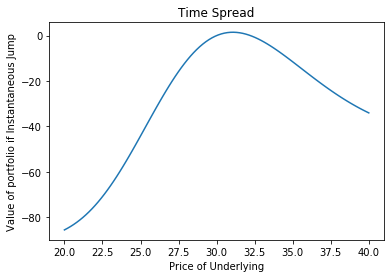

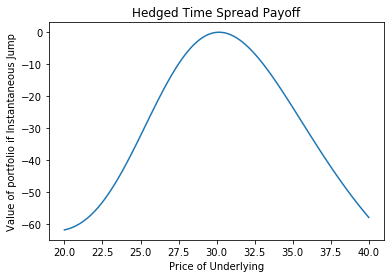

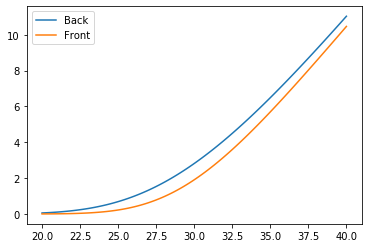

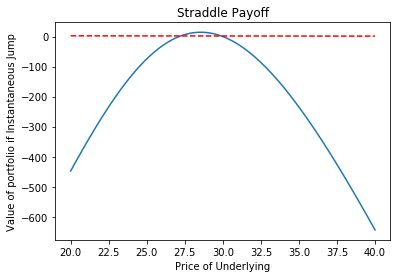

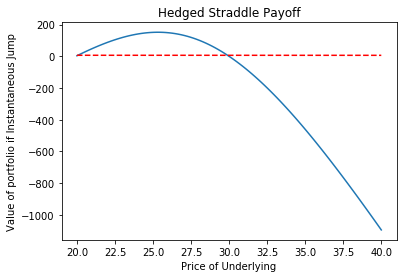

In [ ]:
baml.strike = 30
option = Euro_Option(strike = 30, premium = 0, lifetime = 256, tp = 'call', asset = baml)
x_axis = np.linspace(20,40, 100)
sz = 100

def time_spread(t1=256, t2=128, strike = 30, days_elapsed =0, hedged = True, greeks = None):
    #Time spread: short prompt, long back
    option = Euro_Option(strike = strike, premium = 0, lifetime = t1, tp = 'call', asset = baml)
    option2 = Euro_Option(strike = strike, premium = 0, lifetime = t2, tp = 'call', asset = baml)
    plot_port_payoff([option, option2], 
                     [sz,-sz],
                     [{'days_elapsed':days_elapsed},{'days_elapsed':days_elapsed},{'spot':0}],
                     x_axis)
    plt.title("Time Spread")
    plt.show()
    if hedged:
        d_hedge = option.calc_greeks()['Delta']
        d_hedge -= option2.calc_greeks(days_elapsed=days_elapsed)['Delta']
        plot_port_payoff([option, option2, baml], 
                         [sz,-sz,d_hedge*sz], 
                         [{'days_elapsed':days_elapsed},{'days_elapsed':days_elapsed},{'spot':0}],
                         x_axis)
        plt.title("Hedged Time Spread Payoff")
        plt.show()
        val = [option.calc_value(spot = i, days_elapsed=days_elapsed)  for i in x_axis]
        val2 = [option2.calc_value(spot = i, days_elapsed=days_elapsed)  for i in x_axis]
        plt.plot(x_axis, val)
        plt.plot(x_axis, val2)
    #     plt.fill_between(x_axis, val, val2, color = 'grey')
        plt.legend(("Back", "Front"))
        plt.show()
time_spread(days_elapsed=0)

#Stradle: Short Put and Call w/ same strike
def straddle(strike):
    #Note that this position is NOT delta nuetral if strike = spot as the stock is expected to grow. 
    #Based on expectations upon expiry call is slightly in the money.
    option = Euro_Option(strike = strike, premium = 0, lifetime = 256, tp = 'call', asset = baml)
    p_option = Euro_Option(strike = strike, premium = 0, lifetime = 256, tp = 'put', asset = baml)
   
    plot_port_payoff([option, p_option], [-sz,-sz], [{'days_elapsed':0},{'days_elapsed':0}], x_axis, tangent = True)
    plt.title("Straddle Payoff")
    plt.show()

    d_hedge = -option.calc_greeks()['Delta']
    d_hedge -= p_option.calc_greeks()['Delta']
    plot_port_payoff([option, p_option, baml], [-sz, -sz, sz*d_hedge], [{'days_elapsed':0},{'days_elapsed':0},{'spot':0}], x_axis, tangent = True)
    plt.title("Hedged Straddle Payoff")
    plt.show()
straddle(30) 
# straddle(30*1.08) #fixes 'issue' with straddle

# d_hedge += option.calc_greeks(days_elapsed=250)['Delta']
# plot_port_payoff([option, option, stock], [sz0,sz0, -sz0*d_hedge], [{'days_elapsed':0},{'days_elapsed':250},{'spot':0}], x_axis)


# Below will Plot the greeks or total value of a given portfolio with the  given weights, expiry

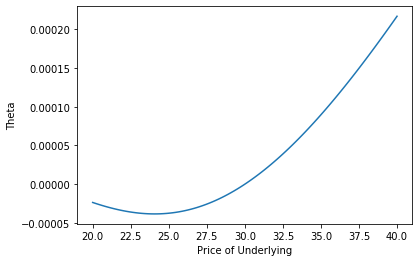

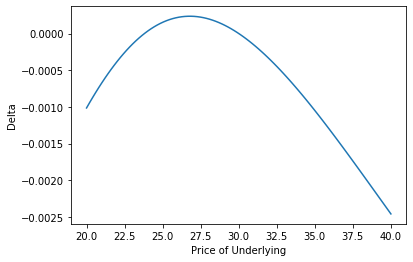

In [ ]:
#Make Arbitrary Spread
oil = Stock(price0 = 45, exp_vol = 0.5, name = "BAC")
option = Euro_Option(strike = 45, premium = 6, lifetime = 256, tp = 'call', asset = oil)
p_option = Euro_Option(strike = 45, premium = 6, lifetime = 256, tp = 'put', asset = oil)
 
instr = [option , option , p_option, option, oil]
weights = [1, -1, 1, -1, 5]
kwarg_lst = [{'days_elapsed':0}, {'days_elapsed':9}, {'days_elapsed':7}, {'days_elapsed':5}]
plot_port_greek(instr, weights, kwarg_lst, x_axis, greek='Theta')
plt.show()
plot_port_greek(instr, weights, kwarg_lst,x_axis)

In [ ]:











#Make animations
fig = plt.figure()
ax = plt.axes(xlim=(40, 60), ylim=(-10, 10))#sets limits
line, = ax.plot([], [], lw=2)


def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def anim_price(option, t, iv = None):
    "Animate the change in price of an option from issuance to expiry"
    spot = option.asset.true_prices[t]
    scale = 10#max(underlying_prx) - min(underlying_prx)
    stock_prices = np.arange(option.strike - scale, self.strike + scale, scale/20)
    y = [option.calc_value(i, days_elapsed=t, iv = iv) for i in stock_prices]
    print(stock_prices, y)
    line.set_data(stock_prices, y)
    return line,

animate = lambda i: anim_price(call2, i)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

#need to get saving working to display
# anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

1.0378153839595503 1.0392304845413265 0.281206338134709 0.28284271247461906


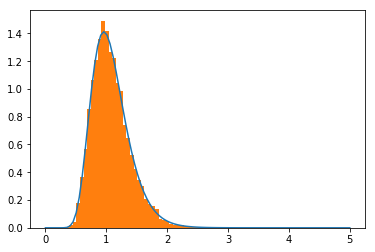

In [ ]:
def plot_total_ret(option, price_idx = None):
    "Given an asset, plot the distribution of it's total returns"
    n = option.lifetime
    lognorm_scale = np.exp(option.asset.ret_dist.kwds['loc']*n)
    lognorm_shape = option.asset.ret_dist.kwds['scale']*(n**0.5)#takes SD
    p_0 = option.asset.price0
    total_ret_dist = lognorm(loc = 0, s = lognorm_shape, scale = lognorm_scale)
    if price_idx is None:
        price_idx =  np.linspace(p_0*max(0,lognorm_scale - 3*lognorm_shape), p_0*(lognorm_scale + 3*lognorm_shape), 1000)
    plt.plot(price_idx, total_ret_dist.pdf(price_idx))


##Show that distribution matches
option = Euro_Option(strike = 350, premium = 10, lifetime = 128, tp = 'call', asset = tesla)
n = option.lifetime
lognorm_scale = np.exp(option.asset.ret_dist.kwds['loc']*n)
lognorm_shape = option.asset.ret_dist.kwds['scale']*(n**0.5)#takes SD
p_0 = option.asset.price0

total_ret_dist = lognorm(loc = 0, s = lognorm_shape, scale = lognorm_scale)
price_idx = np.linspace(p_0*max(0,lognorm_scale - 3*lognorm_shape), p_0*(lognorm_scale + 3*lognorm_shape), 1000)
price_idx = np.linspace(0,5,100)
plt.plot(price_idx, total_ret_dist.pdf(price_idx))

s = 10000
samples = [0]*s
num_days = option.lifetime
for i in range(s):
    samples[i] = np.exp(np.cumsum(option.asset.ret_dist.rvs(num_days)))[-1]
shape, loc, scale = lognorm.fit(samples, floc = 0)
print(scale, lognorm_scale, shape, lognorm_shape)
plt.hist(samples, density = True, bins = 50)
plt.show()

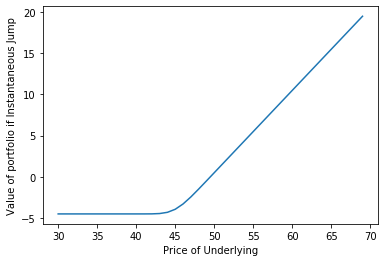

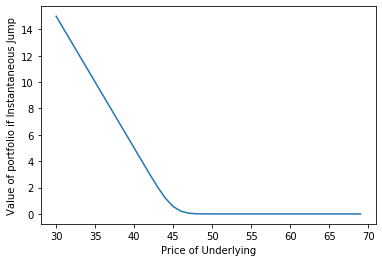

In [ ]:
oil = Stock(price0 = 45, exp_vol = 0.5, name = "BAC")
c_option = Euro_Option(strike = 45, premium = 6, lifetime = 256, tp = 'call', asset = oil)
p_option = Euro_Option(strike = 45, premium = 6, lifetime = 256, tp = 'put', asset = oil)
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
    plot_port_payoff([oil, p_option], weights=[1,1], kwarg_lst=[{}, {'spot' : 45, 'days_elapsed':255}], x_axis = np.arange(30,70,1))
    plt.show()
    plot_port_payoff([oil, c_option], weights=[-1,1], kwarg_lst=[{}, {'spot' : 45, 'days_elapsed':255}], x_axis = np.arange(30,70,1))

Option Value:  423.5790207226621
Initial Portfolio Value: -6203.349819707781 [100, -55.22440700358702]
Theta Bill, value change due to passage of time: -3.71818118201827
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.71818118201827


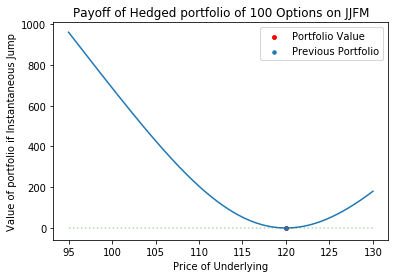

New Portfolio Value:  -6202.100787489185 profit -3.7181811820173607 [100, -55.183013558581905] 

Theta Bill, value change due to passage of time: -3.742759127613681
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.742759127613681


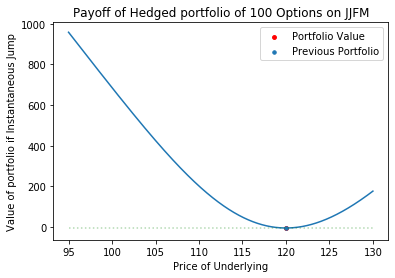

New Portfolio Value:  -6200.835425363531 profit -3.7427591276145904 [100, -55.14127921480467] 

Theta Bill, value change due to passage of time: -3.767942309731552
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.767942309731552


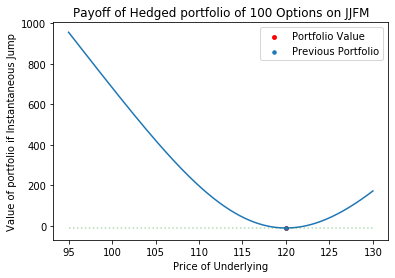

New Portfolio Value:  -6199.5533339606045 profit -3.767942309731552 [100, -55.099195600532525] 

Theta Bill, value change due to passage of time: -3.7937560584141465
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.7937560584141465


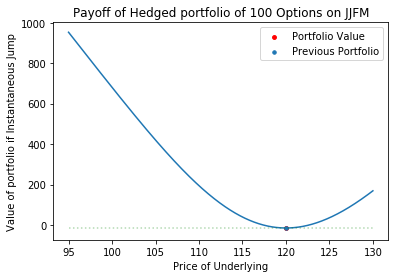

New Portfolio Value:  -6198.254097250232 profit -3.7937560584141465 [100, -55.05675399412597] 

Theta Bill, value change due to passage of time: -3.820227213058388
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.820227213058388


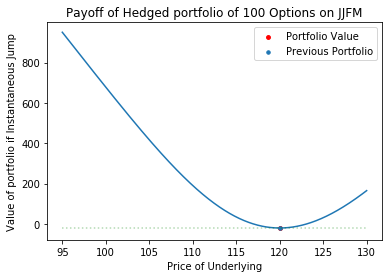

New Portfolio Value:  -6196.937281550936 profit -3.820227213058388 [100, -55.01394530318968] 

Theta Bill, value change due to passage of time: -3.8473842400389913
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.8473842400389913


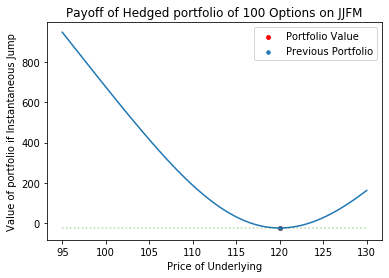

New Portfolio Value:  -6195.602434461359 profit -3.8473842400389913 [100, -54.970760042109546] 

Theta Bill, value change due to passage of time: -3.8752573617557573
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.8752573617557573


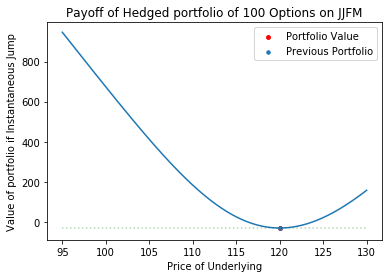

New Portfolio Value:  -6194.249083707015 profit -3.8752573617557573 [100, -54.92718830780872] 

Theta Bill, value change due to passage of time: -3.903878698412882
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.903878698412882


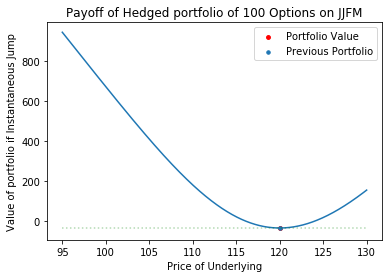

New Portfolio Value:  -6192.876735894002 profit -3.9038786984119724 [100, -54.88321975354684] 

Theta Bill, value change due to passage of time: -3.933282424041863
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.933282424041863


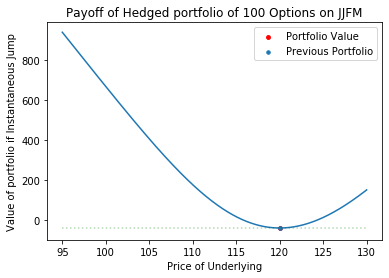

New Portfolio Value:  -6191.48487516032 profit -3.933282424041863 [100, -54.838843560565806] 

Theta Bill, value change due to passage of time: -3.9635049384951344
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.9635049384951344


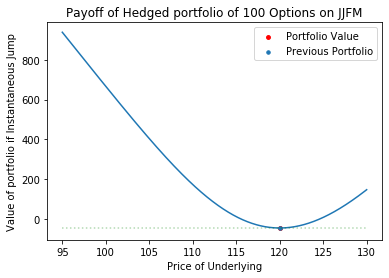

New Portfolio Value:  -6190.072961714333 profit -3.9635049384951344 [100, -54.794048407361785] 

Theta Bill, value change due to passage of time: -3.9945850573576536
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -3.9945850573576536


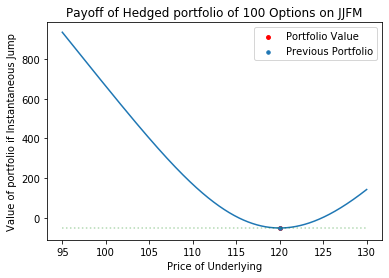

New Portfolio Value:  -6188.64043024859 profit -3.9945850573576536 [100, -54.74882243633594] 

Theta Bill, value change due to passage of time: -4.026564222097477
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.026564222097477


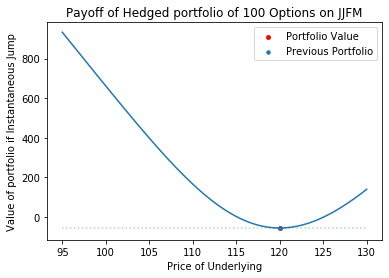

New Portfolio Value:  -6187.186688215798 profit -4.026564222097477 [100, -54.7031532175452] 

Theta Bill, value change due to passage of time: -4.0594867329473345
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.0594867329473345


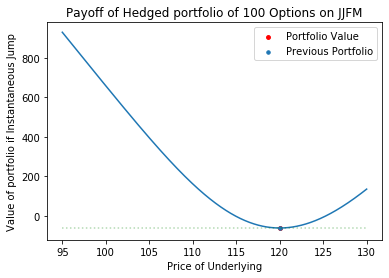

New Portfolio Value:  -6185.711113951967 profit -4.059486732946425 [100, -54.65702770923871] 

Theta Bill, value change due to passage of time: -4.093400007573109
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.093400007573109


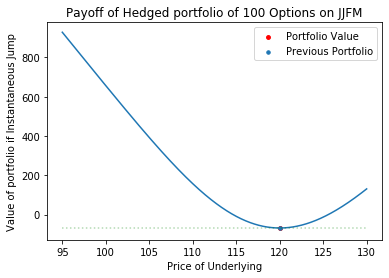

New Portfolio Value:  -6184.213054629862 profit -4.093400007573109 [100, -54.61043221482473] 

Theta Bill, value change due to passage of time: -4.128354868921633
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.128354868921633


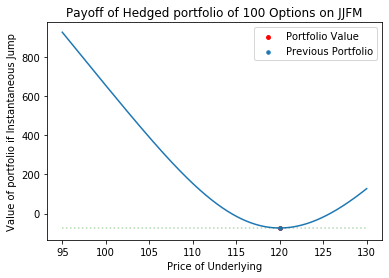

New Portfolio Value:  -6182.691824023608 profit -4.128354868921633 [100, -54.563352335864934] 

Theta Bill, value change due to passage of time: -4.1644058662250245
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.1644058662250245


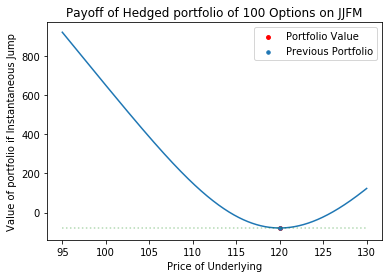

New Portfolio Value:  -6181.146700062684 profit -4.1644058662250245 [100, -54.515772920638696] 

Theta Bill, value change due to passage of time: -4.201611633816356
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.201611633816356


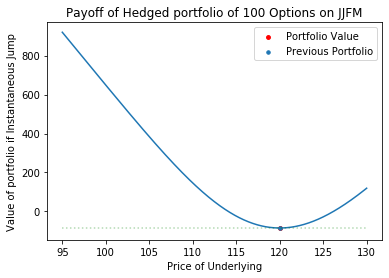

New Portfolio Value:  -6179.5769221505625 profit -4.201611633816356 [100, -54.46767800775588] 

Theta Bill, value change due to passage of time: -4.240035293065375
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.240035293065375


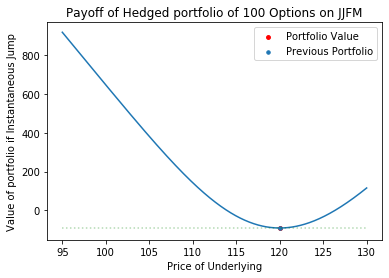

New Portfolio Value:  -6177.981688219674 profit -4.240035293066285 [100, -54.41905076422292] 

Theta Bill, value change due to passage of time: -4.279744903753453
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.279744903753453


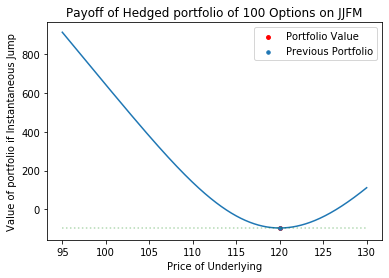

New Portfolio Value:  -6176.360151490286 profit -4.279744903751634 [100, -54.36987341728009] 

Theta Bill, value change due to passage of time: -4.320813972205542
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.320813972205542


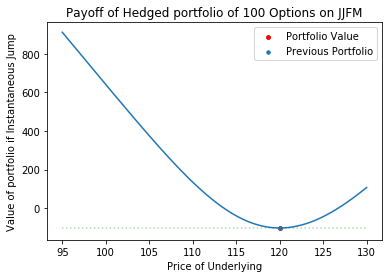

New Portfolio Value:  -6174.71141689611 profit -4.320813972205542 [100, -54.32012717922691] 

Theta Bill, value change due to passage of time: -4.363322024833906
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.363322024833906


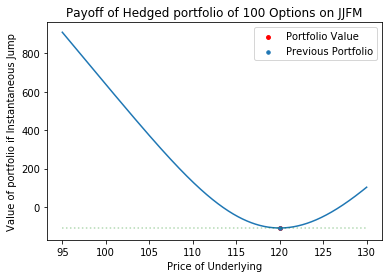

New Portfolio Value:  -6173.0345371337 profit -4.363322024833906 [100, -54.26979216433321] 

Theta Bill, value change due to passage of time: -4.407355257252675
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.407355257252675


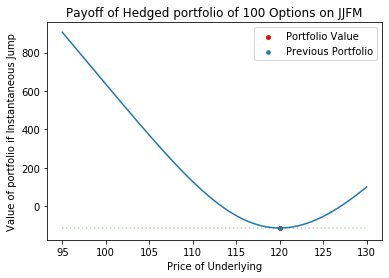

New Portfolio Value:  -6171.328508286124 profit -4.407355257252675 [100, -54.21884729679297] 

Theta Bill, value change due to passage of time: -4.453007271087699
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.453007271087699


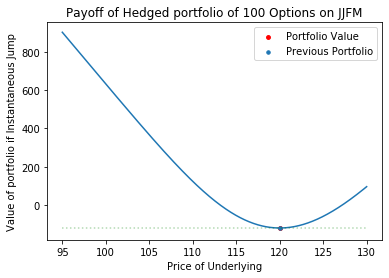

New Portfolio Value:  -6169.5922649634385 profit -4.453007271087699 [100, -54.16727020851153] 

Theta Bill, value change due to passage of time: -4.500379912721655
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.500379912721655


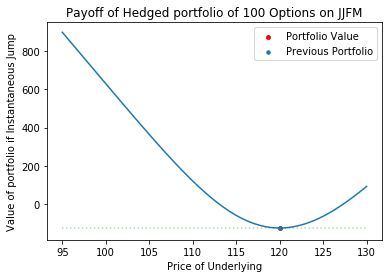

New Portfolio Value:  -6167.824674893059 profit -4.500379912721655 [100, -54.11503712531902] 

Theta Bill, value change due to passage of time: -4.549584231214794
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.549584231214794


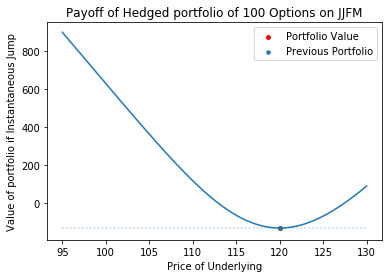

New Portfolio Value:  -6166.024532881987 profit -4.549584231215704 [100, -54.062122739966625] 

Theta Bill, value change due to passage of time: -4.600741575809479
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.600741575809479


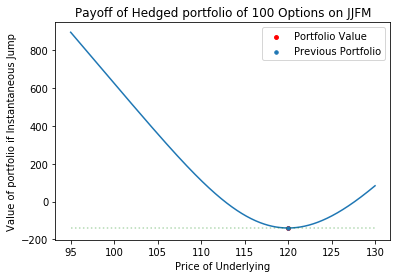

New Portfolio Value:  -6164.190554059308 profit -4.600741575810389 [100, -54.00850006997921] 

Theta Bill, value change due to passage of time: -4.653984857828618
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.653984857828618


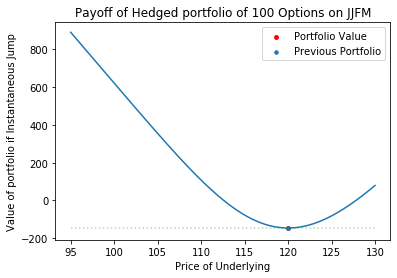

New Portfolio Value:  -6162.321366291267 profit -4.653984857828618 [100, -53.954140298096966] 

Theta Bill, value change due to passage of time: -4.709460006792142
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.709460006792142


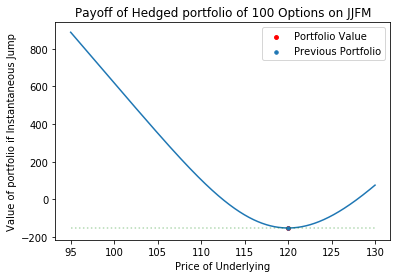

New Portfolio Value:  -6160.415501641544 profit -4.709460006792142 [100, -53.899012592626015] 

Theta Bill, value change due to passage of time: -4.767327657174974
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.767327657174974


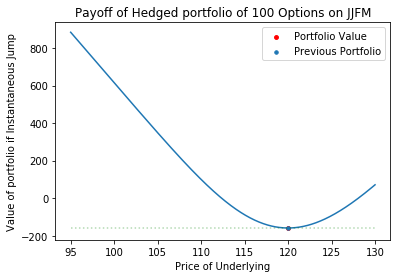

New Portfolio Value:  -6158.471386725597 profit -4.767327657174974 [100, -53.84308390451666] 

Theta Bill, value change due to passage of time: -4.827765110198925
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.827765110198925


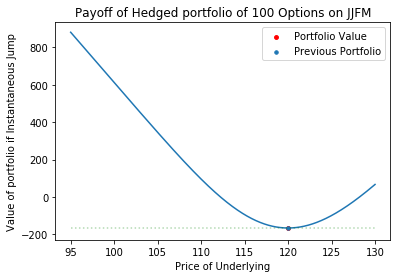

New Portfolio Value:  -6156.487331778751 profit -4.827765110198925 [100, -53.786318737374614] 

Theta Bill, value change due to passage of time: -4.890968625350979
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.890968625350979


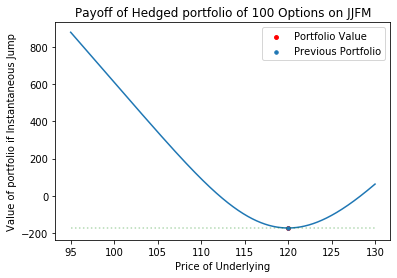

New Portfolio Value:  -6154.4615182219495 profit -4.8909686253518885 [100, -53.728678885856674] 

Theta Bill, value change due to passage of time: -4.957156109144307
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -4.957156109144307


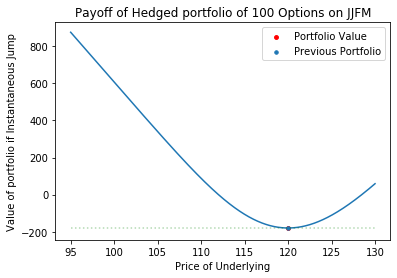

New Portfolio Value:  -6152.391984464814 profit -4.957156109144307 [100, -53.670123136971014] 

Theta Bill, value change due to passage of time: -5.026570285156595
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.026570285156595


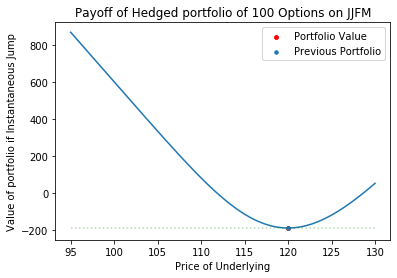

New Portfolio Value:  -6150.276609630512 profit -5.026570285156595 [100, -53.61060692764219] 

Theta Bill, value change due to passage of time: -5.099482450684263
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.099482450684263


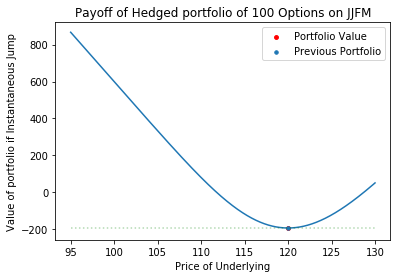

New Portfolio Value:  -6148.1130948180835 profit -5.099482450684263 [100, -53.55008195044958] 

Theta Bill, value change due to passage of time: -5.176196952653299
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.176196952653299


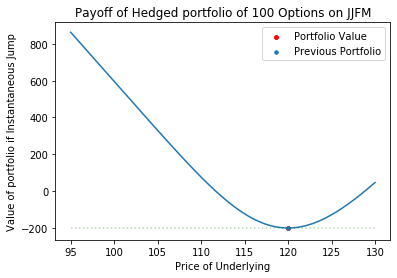

New Portfolio Value:  -6145.898941430757 profit -5.176196952653299 [100, -53.488495697616415] 

Theta Bill, value change due to passage of time: -5.257056551560709
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.257056551560709


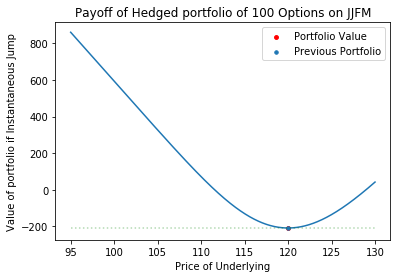

New Portfolio Value:  -6143.6314259883775 profit -5.257056551559799 [100, -53.42579093100025] 

Theta Bill, value change due to passage of time: -5.342448889406114
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.342448889406114


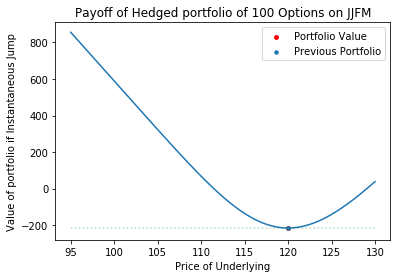

New Portfolio Value:  -6141.307570700455 profit -5.342448889406114 [100, -53.36190506285584] 

Theta Bill, value change due to passage of time: -5.432814340663754
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.432814340663754


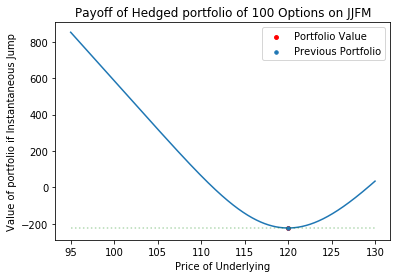

New Portfolio Value:  -6138.924108893508 profit -5.432814340663754 [100, -53.29676942829242] 

Theta Bill, value change due to passage of time: -5.528655610082751
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.528655610082751


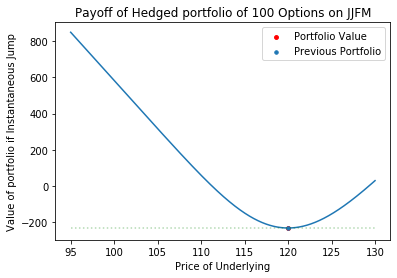

New Portfolio Value:  -6136.477444148189 profit -5.528655610083661 [100, -53.23030842533073] 

Theta Bill, value change due to passage of time: -5.630549555950893
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.630549555950893


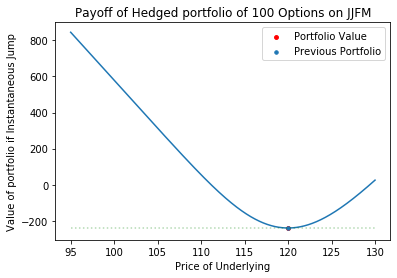

New Portfolio Value:  -6133.963601687806 profit -5.630549555950893 [100, -53.16243849186129] 

Theta Bill, value change due to passage of time: -5.739161875875652
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.739161875875652


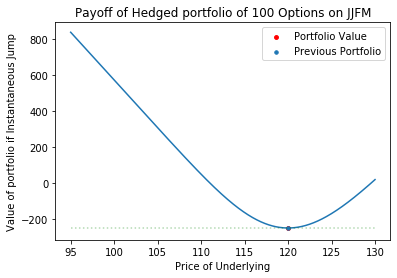

New Portfolio Value:  -6131.378170142844 profit -5.739161875875652 [100, -53.09306688002098] 

Theta Bill, value change due to passage of time: -5.8552655118865005
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.8552655118865005


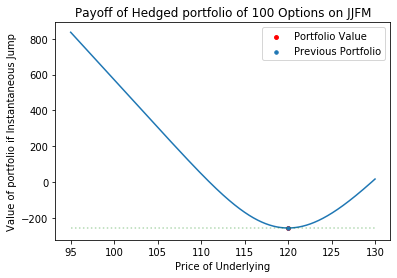

New Portfolio Value:  -6128.716231254488 profit -5.8552655118865005 [100, -53.02209017668562] 

Theta Bill, value change due to passage of time: -5.979763942220416
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -5.979763942220416


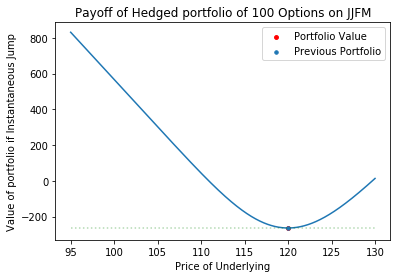

New Portfolio Value:  -6125.972274315534 profit -5.979763942220416 [100, -52.94939250267584] 

Theta Bill, value change due to passage of time: -6.1137209714970595
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -6.1137209714970595


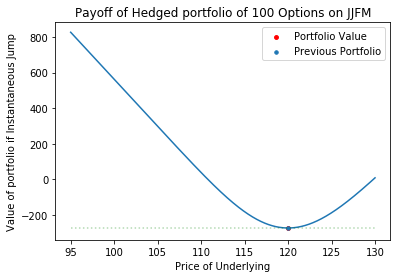

New Portfolio Value:  -6123.140091091373 profit -6.113720971497969 [100, -52.874843301045345] 

Theta Bill, value change due to passage of time: -6.258399277110584
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -6.258399277110584


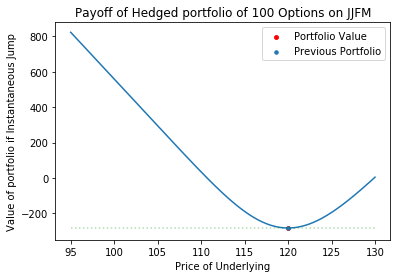

New Portfolio Value:  -6120.212645484495 profit -6.258399277110584 [100, -52.798294593678776] 

Theta Bill, value change due to passage of time: -6.415310926655366
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -6.415310926655366


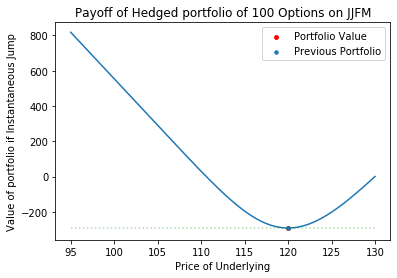

New Portfolio Value:  -6117.181910100347 profit -6.415310926655366 [100, -52.719577541088746] 

Theta Bill, value change due to passage of time: -6.586284524973053
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -6.586284524973053


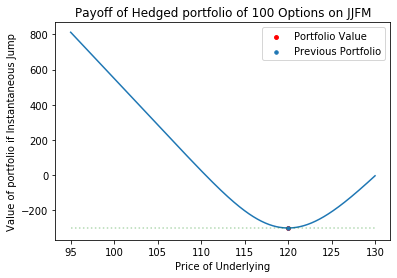

New Portfolio Value:  -6114.038658820771 profit -6.586284524973053 [100, -52.638498076050844] 

Theta Bill, value change due to passage of time: -6.773555875744023
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -6.773555875744023


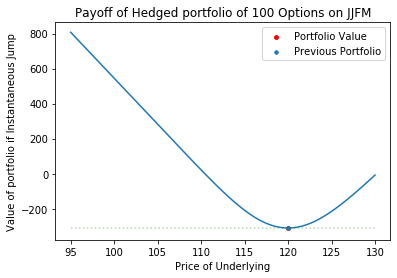

New Portfolio Value:  -6110.772199981648 profit -6.773555875744023 [100, -52.55483128676028] 

Theta Bill, value change due to passage of time: -6.979892557250423
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -6.979892557250423


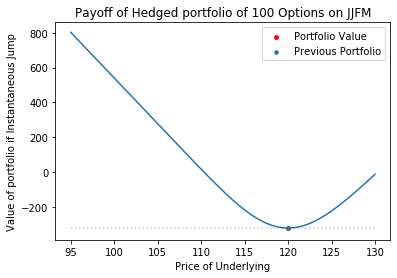

New Portfolio Value:  -6107.370027939847 profit -6.979892557251333 [100, -52.468314081768185] 

Theta Bill, value change due to passage of time: -7.208768510028676
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -7.208768510028676


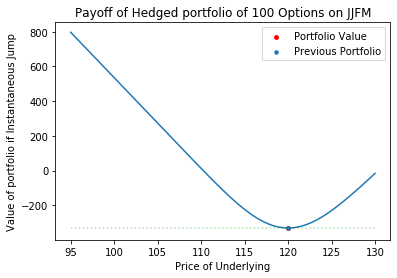

New Portfolio Value:  -6103.817360271108 profit -7.208768510028676 [100, -52.37863544694512] 

Theta Bill, value change due to passage of time: -7.464614252608953
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -7.464614252608953


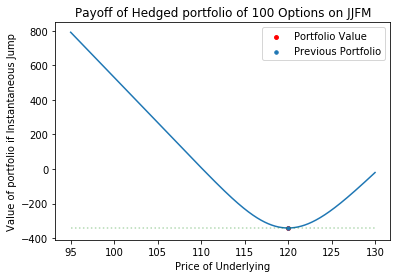

New Portfolio Value:  -6100.096511063414 profit -7.464614252609863 [100, -52.285423251442595] 

Theta Bill, value change due to passage of time: -7.753184790521118
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -7.753184790521118


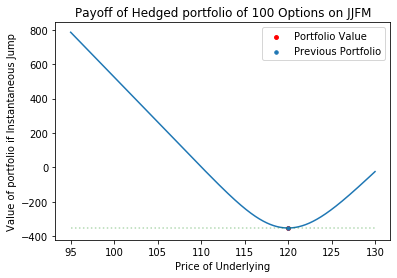

New Portfolio Value:  -6096.186023220941 profit -7.753184790521118 [100, -52.18822597950098] 

Theta Bill, value change due to passage of time: -8.082116838530055
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -8.082116838530055


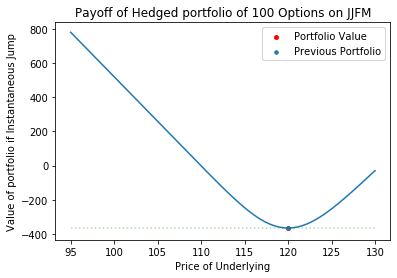

New Portfolio Value:  -6092.059435789451 profit -8.082116838530055 [100, -52.086486777250805] 

Theta Bill, value change due to passage of time: -8.461802531502144
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -8.461802531502144


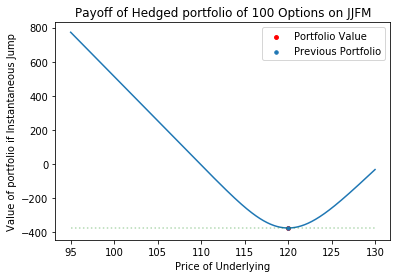

New Portfolio Value:  -6087.683479029123 profit -8.461802531502144 [100, -51.979505449818895] 

Theta Bill, value change due to passage of time: -8.90681691660211
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -8.90681691660211


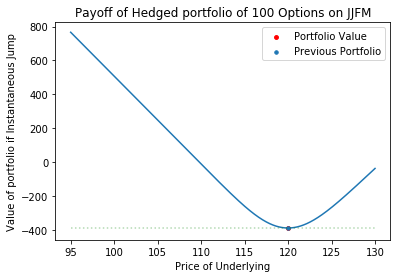

New Portfolio Value:  -6083.015334566286 profit -8.90681691660302 [100, -51.86638077165689] 

Theta Bill, value change due to passage of time: -9.438369055625117
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -9.438369055625117


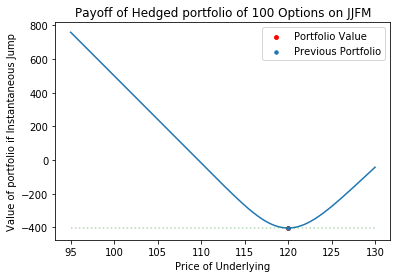

New Portfolio Value:  -6077.998290291398 profit -9.438369055625117 [100, -51.74591899390262] 

Theta Bill, value change due to passage of time: -10.088776988770405
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -10.088776988770405


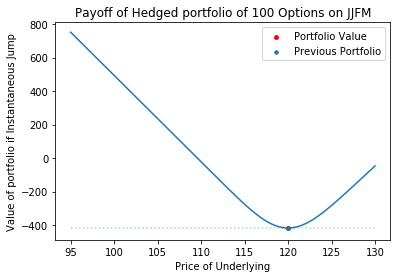

New Portfolio Value:  -6072.5544646829285 profit -10.088776988770405 [100, -51.61648063892562] 

Theta Bill, value change due to passage of time: -10.9102991948821
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -10.9102991948821


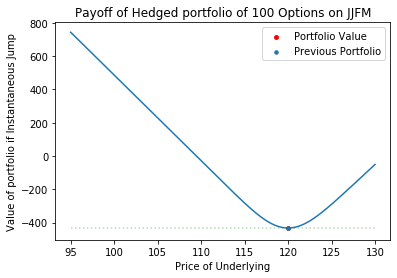

New Portfolio Value:  -6066.571747821184 profit -10.9102991948821 [100, -51.475705505120395] 

Theta Bill, value change due to passage of time: -11.994447018233586
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -11.994447018233586


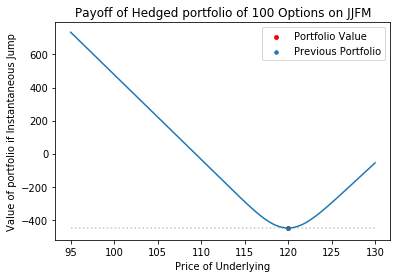

New Portfolio Value:  -6059.87809616531 profit -11.994447018233586 [100, -51.319971349502836] 

Theta Bill, value change due to passage of time: -13.52069356782522
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -13.52069356782522


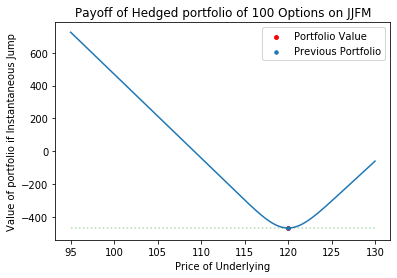

New Portfolio Value:  -6052.183933045994 profit -13.52069356782522 [100, -51.14318087711] 

Theta Bill, value change due to passage of time: -15.908969120639995
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -15.908969120639995


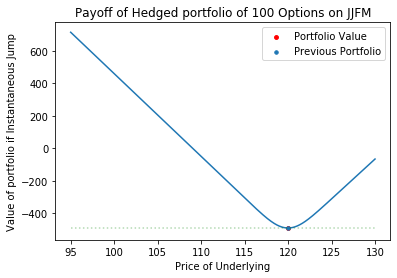

New Portfolio Value:  -6042.924700878657 profit -15.908969120639995 [100, -50.93344586637685] 

Theta Bill, value change due to passage of time: -20.522757166515476
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -20.522757166515476


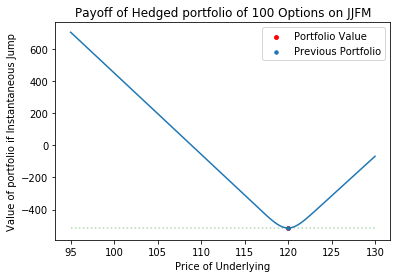

New Portfolio Value:  -6030.643076397495 profit -20.522757166514566 [100, -50.660076019312875] 

Theta Bill, value change due to passage of time: -48.56604592004987
Gamma Scalping return: Gain from prices changing Instantly:  0.0
Total Return since previous:  -48.56604592004987


TypeError: ignored

In [ ]:
st = Stock(price0=125, exp_ret = 0.05)
st.true_prices = [125.000 	, 126.223 	, 127.461 	, 125.302 	, 124.804 	, 126.734 	, 123.511 	, 122.424 	, 123.540 	, 119.376 	, 117.068 	, 114.373 	, 109.192 	, 109.157 	, 108.577 	, 107.746 	, 105.659 	, 108.030 	, 108.497 	, 107.959 	, 107.031 	, 108.050 	, 109.465 	, 109.719 	, 110.416 	, 107.422 	, 111.326 	, 114.373 	, 115.675 	, 117.766 	, 118.950 	, 115.763 	, 115.782 	, 118.533 	, 115.774 	, 118.721 	, 118.018 	, 116.928 	, 115.865 	, 117.783 	, 119.522 	, 118.578 	, 116.978 	, 114.931 	, 114.058 	, 115.767 	, 115.619 	, 114.195 	, 112.672 	, 110.387 	, 108.420 	, 108.343 	, 106.750 	, 107.805 	, 106.835 	, 104.603 	, 103.926 	, 101.990 	, 103.777 	, 102.289 	, 100.894 	, 101.508 	, 100.361 	, 97.111 	,]
op = Euro_Option(strike=120, lifetime = 63, tp="call", premium = 4.49)
# op.calc_iv()*252**0.5
x_axis =  np.linspace(95, 130, 1000)

hedge_ex(op,x_axis)
# forward = 125*np.exp(0.05*63/252)
# print(forward, forward/120)
# np.log(forward/120)
op.calc_value(spot=125, iv=0.4)

-0.4313398199748108 0.3331106503427109
Expected Value:  16.33660057185608 6.634624431510815
Same IV Current Value:  23.145103222562625
Same IV New Value:  118.86968698498572
Old IV New Value:  110.68626218749023
3.571786219882059e-27
[6.634624431510815, 10.4576477237203, 15.249971601309767, 14.85458443348216, 16.673615996603303, 110.68626218749023]
[0.1477412656302124, 0.21812825148553783, 0.30021862042183906, 0.30836235357324326, 0.3524925945513824, 0.9469908007951116]
[0.00032438892984069164, 0.00042982101604247, 0.0005308943824966931, 0.0005728097409610803, 0.0006485708682540178, 0.00019250160573738615]


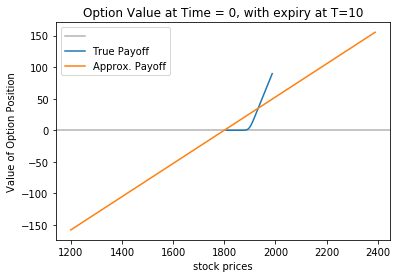

In [ ]:
import numpy as np
from scipy.stats import norm
S = 125

def d1(K, sigma):
  return (np.log(S/K) + (0.05 + 0.5*sigma**2))/sigma

def d2(K,sigma):
  return d1(K,sigma) - sigma

def call(d1, d2, K):
  return S*norm.cdf(d1) - K*0.951*norm.cdf(d2) 

#1 is 40%
#2 is 30%
#3 20%
#4 is 24%
K = 150
sig = 0.24
print(d1(K, sig), norm.cdf(d1(K, sig)))
# for sig in (0.20,0.24,0.30,0.40):
#   print(d1(K, sig), d2(K,sig))
#   print( call(d1(K, sig), d2(K,sig), K) 
#   )
amzn = Stock(price0 = 1800, exp_vol=0.41/16)
a_call = Euro_Option(asset= amzn, strike =1900, lifetime=10, tp='call')
print("Expected Value: ", a_call.calc_value(spot=1800, iv=0.35/16), a_call.calc_value(spot=1800, iv=0.25/16))
print("Same IV Current Value: ", a_call.calc_value(spot=1800, iv=0.41/16, days_elapsed=0))
print("Same IV New Value: ", a_call.calc_value(spot=2008, iv=0.41/16, days_elapsed=5))
print("Old IV New Value: ", a_call.calc_value(spot=2008, iv=0.25/16, days_elapsed=5))
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
  a_call.make_payoff(scale='auto')
  k = 1800
  x0 = a_call.calc_value(spot=k, iv=0.41/16)
  d = a_call.calc_greeks(iv=0.41/16)['Delta']
  g = a_call.calc_greeks(iv=0.01/16)['Gamma']
  x = np.arange(1200,2400,10)
  plt.plot(x, [d*(i-k) + 0.5*g*(i-k)**2 for i in x])
  plt.legend(["","True Payoff", "Approx. Payoff"])
  # plt.xlim(1700, 1900)
  # plt.ylim(-10,100)
  print(a_call.calc_greeks(spot=1800)['Gamma'])

l = [1800, 1828, 1853, 1858, 1870, 2008]
print([a_call.calc_value(spot=i,days_elapsed=ix, iv=0.25/16) for ix,i in enumerate(l)])
print([a_call.calc_greeks(spot=i, days_elapsed=ix, iv=0.25/16)['Delta'] for ix,i in enumerate(l)])
print([a_call.calc_greeks(spot=i, days_elapsed=ix, iv=0.25/16)['Gamma'] for ix,i in enumerate(l)])

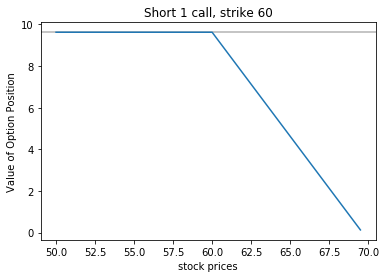

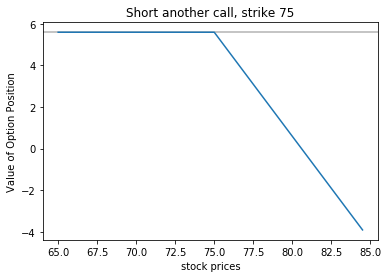

9.624685944228094 5.589165197588892


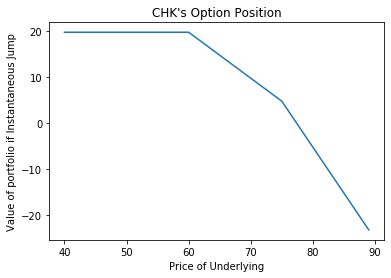

In [ ]:
from matplotlib.collections import LineCollection
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):
  o1 = Euro_Option(strike=60)
  o2 = Euro_Option(strike = 75)
  p1 = o1.calc_value(spot=55, iv=0.5/16)
  p2 = o2.calc_value(spot=55, iv=0.5/16)
  o1.premium=p1
  o2.premium=p2
  fig,ax = o1.make_payoff(position='short', t=256)
  ax.set_title("Short 1 call, strike 60")
  plt.show()
  fig,ax = o2.make_payoff(position='short', t=256)
  ax.set_title("Short another call, strike 75")
  plt.show()
  print(p1,p2)
  plot_port_payoff([o1,o2],[-1,-1], [{'days_elapsed': 256}]*2, np.arange(40,90,1), offset=p1+p2)
  plt.title("CHK's Option Position")